In [1]:
config_file = "/users/kcochran/projects/new_procap_models/modisco_out/procap/"
config_file += "K562/strand_merged_umap/2022-10-05_03-39-32_profile_in/config.json"

In [2]:
# need to specify for every expt

patterns_to_keep = [0,1,2,3,4,5,7,8,9,10,13,14,15]

profile_to_counts_patterns = {0:[2,5], 1:None, 2:[0,1], 3:7, 4:3, 5:4, 7:9,
                              8:None, 9:None, 10:10, 13:6, 14:-1, 15:None}

# This is specific to K562

motif_keys_to_labels = ["BRE/SP", "CA-Inr", "GABPA", "NFY", "NRF1", "ATF1",
                        "YY1", "TA-Inr", "TATA", "THAP11",
                        "AP1",  "CTCF", "ZBTB33"]

In [642]:
import sys
sys.path.append("../2_train_models")
sys.path.append("../5_modisco")

from utils import load_json, get_proj_dir
from report_utils import load_modisco_results
from modiscolite_utils import load_sequences, load_scores, load_observed_profiles
from plot_utils import get_continuous_cmap
from other_motif_utils import trim_motif_by_thresh, trim_two_motifs_by_thresh, plot_motif_on_ax, compute_per_position_ic
from file_configs import ValFilesConfig, TrainFilesConfig

import os
from collections import defaultdict
import gzip
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline


config = load_json(config_file)

proj_dir = config["proj_dir"]

cell_type = config["cell_type"]
model_type = config["model_type"]
timestamp = config["timestamp"]
data_type = config["data_type"]

genome_path = config["genome_path"]
chrom_sizes = config["chrom_sizes"]

in_window = config["in_window"]
out_window = config["out_window"]

slice_len = config["slice"]

peak_path = config["train_val_peak_path"]

scores_path = config["scores_path"]

modisco_results_path = config["results_save_path"]

In [4]:
fig_save_path = proj_dir + "figures/Fig2/"
os.makedirs(fig_save_path, exist_ok=True)

In [5]:
from load_annotations_utils import load_coords_with_summits

coords = load_coords_with_summits(peak_path, in_window=in_window)

In [6]:
scores = load_scores(scores_path,
                     slice_len=slice_len,
                     in_window=in_window)

modisco_results = load_modisco_results(modisco_results_path)

counts_modisco_results = load_modisco_results(modisco_results_path.replace("profile", "counts"))

# need filepaths from these
train_config = TrainFilesConfig(cell_type, model_type, timestamp, data_type)
val_config = ValFilesConfig(cell_type, model_type, timestamp, data_type)

true_profs = load_observed_profiles(train_config.plus_bw_path,
                                    train_config.minus_bw_path,
                                    peak_path,
                                    slice_len=slice_len,
                                    out_window=out_window)

pred_profs = np.exp(np.load(val_config.pred_profiles_train_val_path))

Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32
== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/deepshap_out/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_train_and_val.bed.gz
Profile length: 1000
Num. Examples: 27000


In [7]:
len(coords), scores.shape, true_profs.shape, pred_profs.shape

(27000, (27000, 1000, 4), (27000, 2, 1000), (27000, 2, 1000))

In [8]:
### Load Motifs

from motif_hits_utils import load_motif_hits

motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(cell_type, model_type, timestamp)

Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32


## Main Large Plot

In [224]:
def plot_avg_profile(profiles, ax, prof_width = 200, bottom_ticks=False):
    assert len(profiles.shape) == 3

    profiles = profiles[~np.isnan(profiles).any(axis=1).any(axis=1)]
    profiles = profiles[~np.isnan(profiles).any(axis=1).any(axis=1)]

    # First, normalize the profiles along the output profile dimension
    def normalize(arr, axis=0):
        arr_sum = np.sum(arr, axis=axis, keepdims=True)
        arr_sum[arr_sum == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return arr / arr_sum
    
    profs_norm = normalize(profiles, axis=-1)

    # Compute the mean profiles across all examples
    profs_mean = np.mean(profs_norm, axis=0)

    # Plot the average predictions
    prof_center = profs_mean.shape[-1] // 2
    ax.plot(profs_mean[0, prof_center - prof_width:prof_center + prof_width],
            color="#480CA8", linewidth=0.5)
    ax.plot(-profs_mean[1, prof_center - prof_width:prof_center + prof_width],
            color="#4361EE", linewidth=0.5)

    # Set axes
    max_mean_val = np.max(profs_mean)
    mean_ylim = max_mean_val * 1.1  # Make 5% higher
    ax.set_ylim(-mean_ylim, mean_ylim)
    ax.set_xlim(0, 2 * prof_width)
    ax.label_outer()
    ax.set_yticks([])
    
    if not bottom_ticks:
        ax.set_xticks([])
        for side in ["left", "top", "right", "bottom"]:
            ax.spines[side].set_visible(False)
    else:
        ax.set_xticks([prof_width, 2 * prof_width], [0, prof_width],
                     fontsize=6)
        ax.tick_params("x", length=3)
        
        for side in ["left", "top", "right"]:
            ax.spines[side].set_visible(False)
            
        rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 4, mean_ylim / 5,
                                 clip_on=False, zorder=50, color="white")
        ax.add_patch(rect)
            
        ax.spines['bottom'].set_position(('data', -mean_ylim))
        ax.spines["bottom"].set_color("#333333")
        

def extract_profs_at_motifs(motif_hits, coords, true_profs, pred_profs,
                             in_window, out_window, slice_len, prof_width=200):
        
    def convert_motif_coords_to_prof_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - out_window) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_prof_coords(coords, coord_indexes,
                                                                   motif_starts, motif_ends)
    
    # Get indices of profile above motif
    motif_centers = (motif_starts + motif_ends) // 2
    motif_prof_starts = motif_centers - prof_width
    motif_prof_ends = motif_centers + prof_width
    
    # For each seqlet, fetch the true/predicted profiles
    true_motif_profs = []
    pred_motif_profs = []
    for coord_index, prof_start, prof_end, rc in zip(coord_indexes, motif_prof_starts, motif_prof_ends, motif_rcs):
        if not (prof_start < 0 or prof_end > out_window):
            true_prof = true_profs[coord_index, :, prof_start:prof_end]
            pred_prof = pred_profs[coord_index, :, prof_start:prof_end]
            if rc:
                true_prof = true_prof[::-1, ::-1]
                pred_prof = pred_prof[::-1, ::-1]
        
            true_motif_profs.append(true_prof)
            pred_motif_profs.append(pred_prof)

    true_motif_profs = np.stack(true_motif_profs)
    pred_motif_profs = np.stack(pred_motif_profs)
    
    return true_motif_profs, pred_motif_profs

def plot_cwm_weight_as_circle(ax, cwm_weight):
    cmap = get_continuous_cmap(["#8DEEFF", "#59D8FF", "#024A9D", "#03045E"])
    cmap_color = cmap(cwm_weight)
    ax.add_patch(plt.Circle((0.5, 0.5), cwm_weight * 0.48,
                            facecolor = cmap_color, edgecolor="#030446"))
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(xlim=[0, 1], ylim=[0, 1], aspect=1)

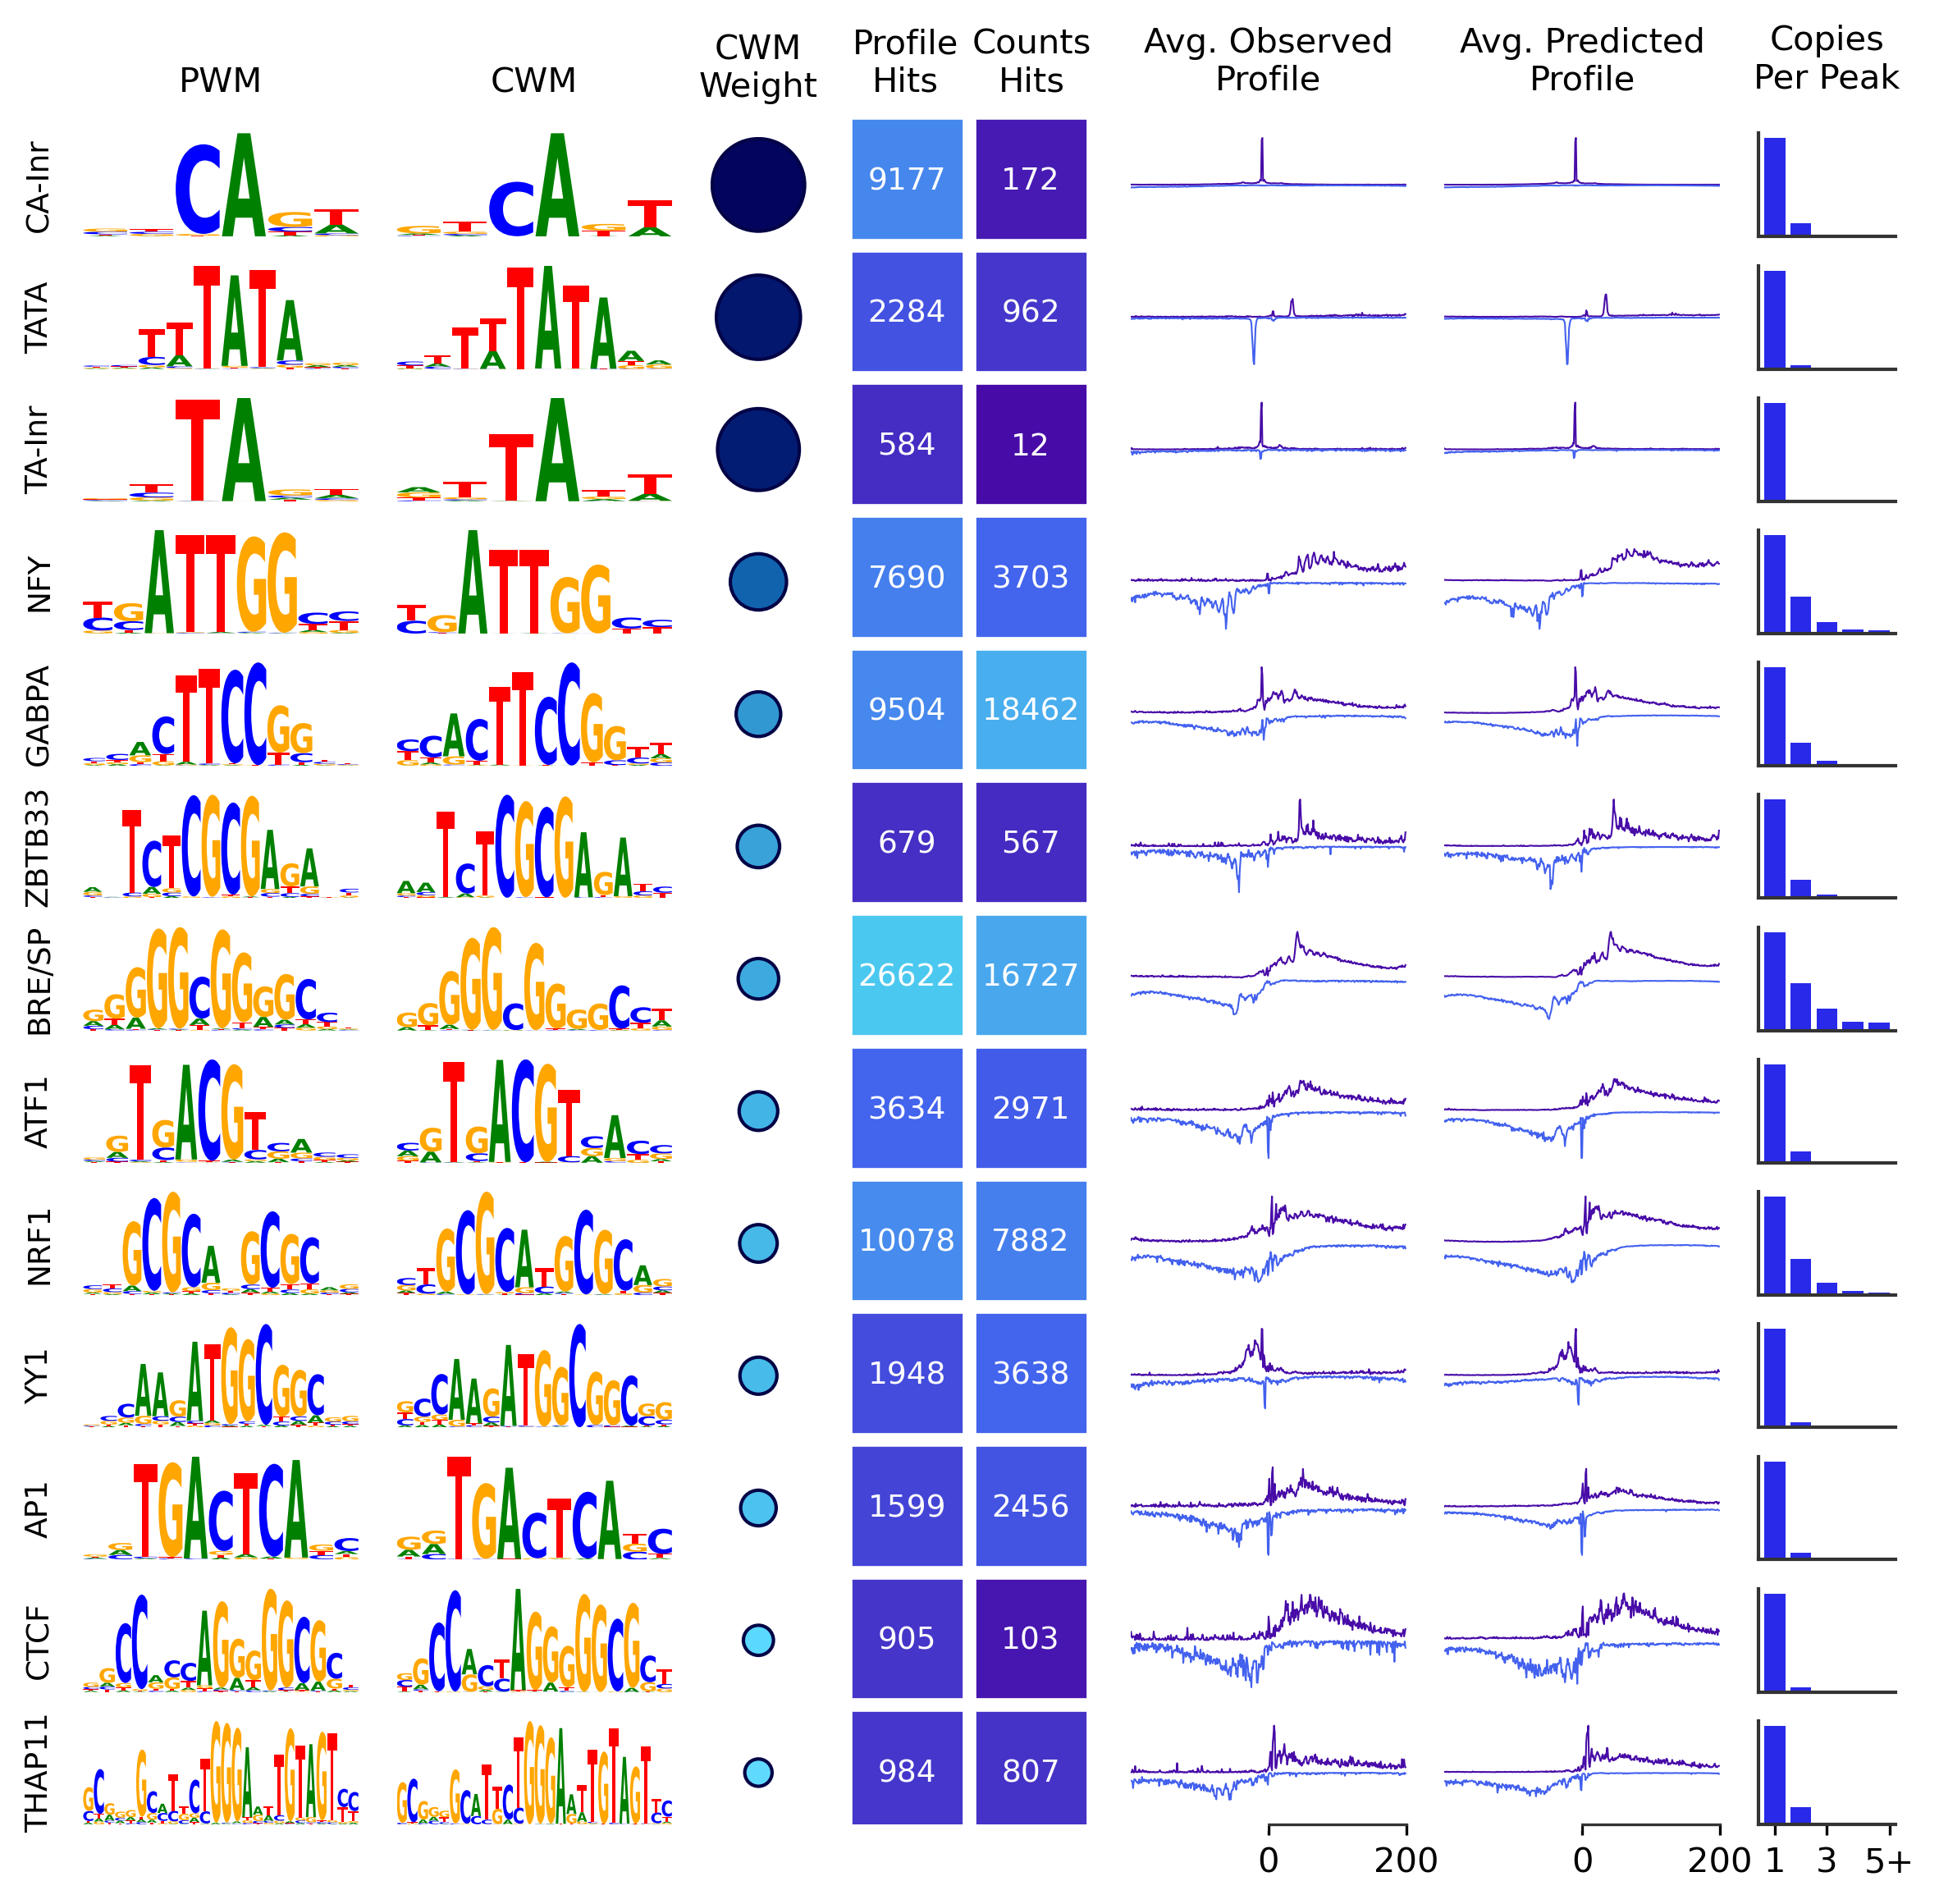

In [228]:
def plot_modisco_hits(modisco_results, patterns_to_keep,
                      motif_hits, motif_hit_counts,
                      coords, true_profs, pred_profs, 
                      in_window, out_window, slice_len,
                      prof_width=200, save_path=None):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    ### first, load up all the data used in the plot
    
    pwms = []
    cwms = []
    cwm_weights = []
    true_profs_list = []
    pred_profs_list = []
    hist_ys = []
    hist_xs = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]

        ppm = pattern["sequence"][:]
        pwm = ppm * compute_per_position_ic(ppm)[:, None]
        pwms.append(pwm)
        
        cwm = pattern["contrib_scores"][:]
        cwms.append(cwm)
        
        cwm_weight = np.max(cwm.sum(axis=-1))
        cwm_weights.append(cwm_weight)

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits["profile"][motif_hits["profile"]["key"] == ax_row_i]

        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     slice_len, prof_width=200)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)

        hist_y, hist_x = np.histogram([num for num in motif_hit_counts["profile"][:, ax_row_i] if num > 0],
                                      bins=range(1, np.max(motif_hit_counts["profile"])))
        hist_ys.append(hist_y)
        hist_xs.append(hist_x)

        
    ### sort everything identically
        
    heatmap_prof_data = motif_hit_counts["profile"].sum(axis=0)
    heatmap_counts_data = motif_hit_counts["counts"].sum(axis=0)
    
    # previous sort order
    #sort_order = np.argsort(heatmap_prof_data)[::-1]
    sort_order = np.argsort(cwm_weights)[::-1]
    
    heatmap_prof_data = heatmap_prof_data[sort_order]
    heatmap_counts_data = heatmap_counts_data[sort_order]
    heatmap_data = np.array((heatmap_prof_data, heatmap_counts_data)).T
    pwms = np.array(pwms)[sort_order]
    cwms = np.array(cwms)[sort_order]
    cwm_weights = np.array(cwm_weights)[sort_order]
    true_profs_list = np.array(true_profs_list, dtype=object)[sort_order]
    pred_profs_list = np.array(pred_profs_list, dtype=object)[sort_order]
    hist_ys = np.array(hist_ys, dtype=object)[sort_order]
    hist_xs = np.array(hist_xs, dtype=object)[sort_order]
    motif_names = np.array(motif_keys_to_labels)[sort_order]
    
    # normalize so max is 1
    cwm_weights = cwm_weights / np.max(cwm_weights)
    
    
    ### with data all loaded, start building plot

    fig, axes = plt.subplots(len(patterns_to_keep) + 1, 7,
                             figsize=(9.5,0.7 * len(patterns_to_keep)),
                             dpi=300,
                             gridspec_kw={"width_ratios":[2,2,0.7,1.8,2,2,1],
                                          "height_ratios":[0.05] + [1] * len(patterns_to_keep),
                                          "hspace":0.3, "wspace":0.17})

    # the top row of subplots are fake (for padding), so remove/hide
    for ax in axes[0, :]:
        ax.remove()

    # modify the subplot arrangement to draw heatmap over a whole column
    axes[0,3].set_axis_off()
    gs1 = axes[0,3].get_gridspec()
    for ax in axes[1:, 3]:
        ax.remove()
    heatmap = fig.add_subplot(gs1[:, 3])

    for ax_row_i in range(len(patterns_to_keep)):
        pwm = pwms[ax_row_i]
        cwm = cwms[ax_row_i]
        cwm_weight = cwm_weights[ax_row_i]
        true_profs = true_profs_list[ax_row_i]
        pred_profs = pred_profs_list[ax_row_i]
        hist_y = hist_ys[ax_row_i]
        hist_x = hist_xs[ax_row_i]
        
        ax_row = axes[ax_row_i+1]
        
        ### plot motif PWM, CWM, CWM height
        
        pwm_trim, cwm_trim = trim_two_motifs_by_thresh(pwm, cwm)
        plot_motif_on_ax(pwm_trim, ax_row[0])
        plot_motif_on_ax(cwm_trim, ax_row[1])
        
        plot_cwm_weight_as_circle(ax_row[2], cwm_weight)
        
        ax_row[0].set_ylabel(motif_names[ax_row_i], fontsize=9, labelpad=5)
        
        if ax_row_i == 0:
            ax_row[0].set_title("PWM", y=1.2, fontsize=10)
            ax_row[1].set_title("CWM", y=1.2, fontsize=10)
            ax_row[2].set_title("CWM\nWeight", y=1.2, fontsize=10)
            
            
        ### plot true/pred profiles

        plot_avg_profile(true_profs, ax_row[4],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1)
        if ax_row_i == 0:
            ax_row[4].set_title("Avg. Observed\nProfile\n", fontsize=10, pad=1.5)

        plot_avg_profile(pred_profs, ax_row[5],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1)
        if ax_row_i == 0:
            ax_row[5].set_title("Avg. Predicted\nProfile\n", fontsize=10, pad=1.5)

        ### plot motif complexity histograms
            
        stop_after = 4
        hist_y = list(hist_y[:stop_after]) + [np.sum(hist_y[stop_after:])]
        hist_x = list(hist_x[:stop_after + 1])
        ax_row[6].bar(hist_x, hist_y, color="#2929ea", alpha=1)

        ax_row[6].tick_params("both", length=3)
        ax_row[6].set_yticks([])
        if ax_row_i == len(patterns_to_keep) - 1:
            xticks = hist_x[:-1] + [hist_x[-1] + 0.4]
            xticks = xticks[::2]
            xticklabels = [str(i) for i in hist_x[:-1]]
            xticklabels = xticklabels[::2]
            xticklabels.append(str(hist_x[-1]) + "+")
            ax_row[6].set_xticks(xticks, xticklabels)
        else:
            ax_row[6].set_xticks([])

        for side in ["left", "bottom"]:
            ax_row[6].spines[side].set_linewidth(1)
            ax_row[6].spines[side].set_color("#333333")
        for side in ["top", "right"]:
            ax_row[6].spines[side].set_visible(False)
            
        if ax_row_i == 0:
            ax_row[6].set_title("Copies\nPer Peak\n", fontsize=10, pad=1.5)

    ### plot heatmaps (columns 2 and 3)

    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')
    heatmap.imshow(np.sqrt(np.concatenate((heatmap_data.T, heatmap_data.T)).T), aspect = "auto", cmap=cmap)

    heatmap.set_xticks(np.arange(3)-.5, minor=True)
    heatmap.xaxis.set_ticks_position("top")
    heatmap.set_xticks([-0.01,1.01], ["Profile\nHits", "Counts\nHits"], fontsize=10)
    heatmap.tick_params(length=0, pad=0)

    # format heatmaps to look better
    heatmap.grid(which="minor", color="w", linestyle='-', linewidth=4)
    heatmap.tick_params(which="minor", bottom=False, left=False, top=False)
    heatmap.tick_params(which="major", bottom=False, left=False, top=False)
    heatmap.set_yticklabels([])
    for side in ["left", "top", "bottom"]:
        heatmap.spines[side].set_visible(False)
    heatmap.spines["right"].set_color("w")
    heatmap.set_yticks(np.arange(len(heatmap_data)+1)-.5, minor=True)
    heatmap.set_ylim(len(heatmap_data) - 0.6, -0.6)

    heatmap.set_xlim(-0.5, 1.5)

    # add text on top of heatmaps
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            if not np.isnan(heatmap_data[i,j]):
                text = heatmap.text(j, i+0.02, int(heatmap_data[i,j]),
                           ha="center", va="center", color="w", fontsize=9)
            else:
                text = heatmap.text(j-0.03, i+0.02, 0,
                           ha="center", va="center", color="#333333", fontsize=9)

    if save_path is not None:
        plt.savefig(save_path)#, dpi=300)
        
    plt.show()
        
            
plot_modisco_hits(modisco_results,
                  patterns_to_keep, motif_hits, motif_hit_counts,
                  coords, true_profs, pred_profs,
                  in_window, out_window, slice_len,
                  save_path = fig_save_path + "main.png")

## Other Plots

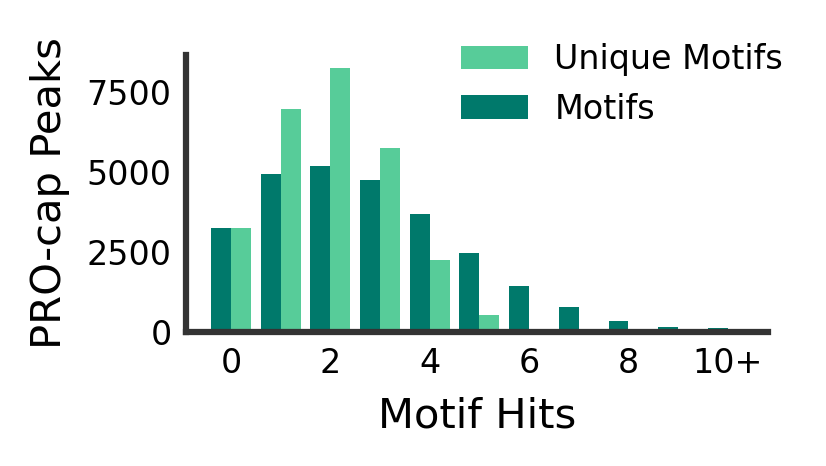

In [270]:
def plot_motif_complexity(motif_hit_counts):
    plt.figure(figsize=(2.5,1.2), dpi=300)
    bar_width = 0.4
    
    # non-unique motif hits
    motif_hits_per_peak = motif_hit_counts.sum(axis=1)
    hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))
    stop_point = 10
    hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
    hist_x = list(hist_x[:stop_point]) + [stop_point]
    
    plt.bar(hist_x, hist_y, color="#00796b", alpha=1, width=bar_width, label="Motifs")
    
    # unique motif hits
    uniq_hits_per_peak = (motif_hit_counts > 0).sum(axis=-1).astype(np.int32)
    hist_y2, hist_x2 = np.histogram(uniq_hits_per_peak, bins=range(np.max(uniq_hits_per_peak) + 2))
    stop_point2 = 9
    hist_y2 = list(hist_y2[:stop_point2]) + [np.sum(hist_y2[stop_point2:])]
    hist_x2 = np.array(list(hist_x2[:stop_point2]) + [stop_point2])
    
    plt.bar(hist_x2 + bar_width, hist_y2, color="#57cc99", alpha=1, width=bar_width, label="Unique Motifs")
    
    plt.xlabel("Motif Hits", fontsize=10)
    plt.ylabel("PRO-cap Peaks", fontsize=10)
    
    xticklabels = []
    for i in hist_x:
        if i < stop_point:
            xticklabels.append(str(i))
        else:
            xticklabels.append(str(stop_point) + "+")
            
    plt.xticks(np.array(hist_x[::2]) + bar_width / 2, xticklabels[::2])
    plt.xlim(-0.7, len(hist_x))
    plt.tick_params("both", length=0, labelsize=8)
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    #plt.legend(frameon=False, bbox_to_anchor=(0.5,1.65), loc="upper center", fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], frameon=False, fontsize=8, bbox_to_anchor=(0.75,1.15), loc="upper center")
    
    plt.show()
    
plot_motif_complexity(motif_hit_counts["profile"])

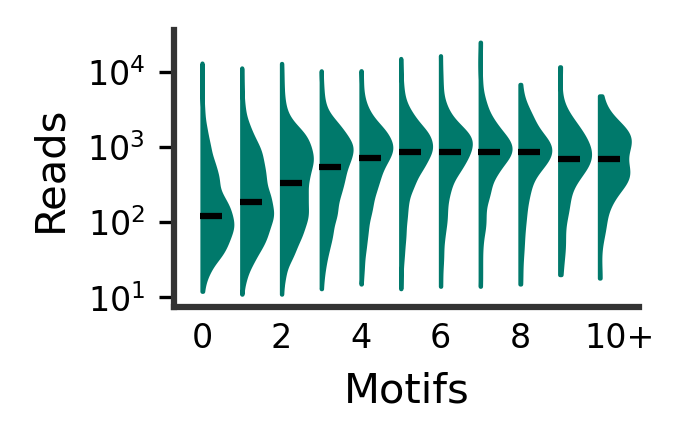

In [195]:
from plot_utils import jitter_dots

def plot_counts_by_num_motifs(motif_hit_counts, true_profs, max_num_motifs=10):
    true_logcounts = np.log10(true_profs.sum(axis=(-1,-2)) + 1)
    
    motif_hit_counts = motif_hit_counts.sum(axis=-1)
    motif_hit_counts_clipped = np.clip(motif_hit_counts, 0, max_num_motifs)
    
    counts_per_num_motifs = []
    median_counts_per_num_motifs = []
    for num_motifs in range(max_num_motifs + 1):
        counts_per_i_motifs = true_logcounts[motif_hit_counts_clipped == num_motifs]
        counts_per_num_motifs.append(counts_per_i_motifs)
        median_counts_per_num_motifs.append(np.median(counts_per_i_motifs))
    
    plt.figure(figsize=(2.,1.2), dpi=300)

    v1 = plt.violinplot(counts_per_num_motifs, points=200,
                       positions=np.arange(0, len(counts_per_num_motifs)),
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=1.5)
    
    for b in v1['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)

        b.set_edgecolor("#00796b")
        b.set_facecolor("#00796b")
        b.set_alpha(1)

    plt.scatter(np.arange(max_num_motifs + 1) + 0.23, median_counts_per_num_motifs,
                marker="_", c="k", s=30, zorder=1)

    plt.xlabel("Motifs", fontsize=10)
    plt.ylabel("Reads", fontsize=10)
    
    xticks = list(range(0, max_num_motifs + 1, 2))
    xticklabels = [str(i) for i in xticks]
    xticklabels[-1] = xticklabels[-1] + "+"
    xticks[-1] = xticks[-1] + 0.5
    plt.xticks(xticks, xticklabels)
    plt.tick_params("x", length=0)
    plt.tick_params("both", labelsize=8)
    plt.xlim(-0.7, max_num_motifs + 1)
    
    yticks = [int(tick) for tick in plt.gca().get_yticks()][1:-1]
    plt.yticks(yticks, [r'$10^' + str(tick) + "$" for tick in yticks])
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()

plot_counts_by_num_motifs(motif_hit_counts["profile"], true_profs)

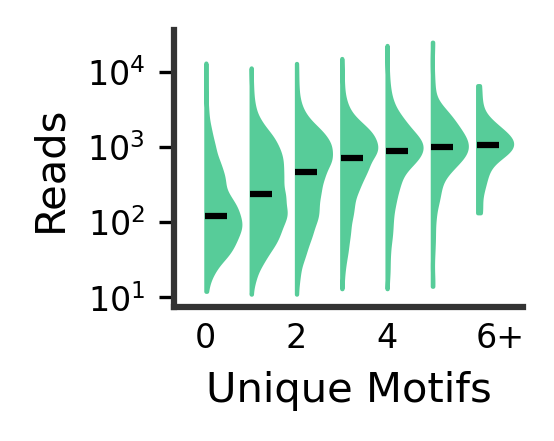

In [196]:
from plot_utils import jitter_dots

def plot_counts_by_num_uniq_motifs(motif_hit_counts, true_profs, max_num_motifs=6):
    true_logcounts = np.log10(true_profs.sum(axis=(-1,-2)) + 1)
    
    motif_hit_counts = (motif_hit_counts > 0).sum(axis=-1)
    motif_hit_counts_clipped = np.clip(motif_hit_counts, 0, max_num_motifs)
    
    counts_per_num_motifs = []
    median_counts_per_num_motifs = []
    for num_motifs in range(max_num_motifs + 1):
        counts_per_i_motifs = true_logcounts[motif_hit_counts_clipped == num_motifs]
        counts_per_num_motifs.append(counts_per_i_motifs)
        median_counts_per_num_motifs.append(np.median(counts_per_i_motifs))
    
    plt.figure(figsize=(1.5,1.2), dpi=300)

    v1 = plt.violinplot(counts_per_num_motifs, points=200,
                       positions=np.arange(0, len(counts_per_num_motifs)),
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=1.5)
    
    for b in v1['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)

        b.set_edgecolor("#57cc99")
        b.set_facecolor("#57cc99")
        b.set_alpha(1)

    plt.scatter(np.arange(max_num_motifs + 1) + 0.22, median_counts_per_num_motifs,
                marker="_", c="k", s=30, zorder=1)

    plt.xlabel("Unique Motifs", fontsize=10)
    plt.ylabel("Reads", fontsize=10)
    
    xticks = list(range(0, max_num_motifs + 1, 2))
    xticklabels = [str(i) for i in xticks]
    xticklabels[-1] = xticklabels[-1] + "+"
    xticks[-1] = xticks[-1] + 0.5
    plt.xticks(xticks, xticklabels)
    plt.tick_params("x", length=0)
    plt.tick_params("both", labelsize=8)
    plt.xlim(-0.7, max_num_motifs + 1)
    
    yticks = [int(tick) for tick in plt.gca().get_yticks()][1:-1]
    plt.yticks(yticks, [r'$10^' + str(tick) + "$" for tick in yticks])
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()


plot_counts_by_num_uniq_motifs(motif_hit_counts["profile"], true_profs)

In [627]:
import statsmodels.api as sm

In [628]:
model = sm.OLS(np.log1p(true_profs.sum(axis=(-1,-2))),
               sm.add_constant(motif_hit_counts["profile"].sum(axis=-1)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5347.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:37:47   Log-Likelihood:                -42174.
No. Observations:               27000   AIC:                         8.435e+04
Df Residuals:                   26998   BIC:                         8.437e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1662      0.012    433.748      0.000       5.143       5.190
x1             0.2510      0.003     73.125      0.000       0.244       0.258
==============================================================================
Omnibus:                      365.769   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.096
Skew:                          -0.218   Prob(JB):                     4.20e-71
Kurtosis:                       2.686   Cond. No.                         6.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [629]:
model = sm.OLS(np.log1p(true_profs.sum(axis=(-1,-2))),
               sm.add_constant((motif_hit_counts["profile"] > 0).sum(axis=-1)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     5027.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:38:05   Log-Likelihood:                -42308.
No. Observations:               27000   AIC:                         8.462e+04
Df Residuals:                   26998   BIC:                         8.464e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0754      0.013    383.319      0.000       5.049       5.101
x1             0.4066      0.006     70.900      0.000       0.395       0.418
==============================================================================
Omnibus:                      426.944   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.983
Skew:                          -0.229   Prob(JB):                     7.52e-81
Kurtosis:                       2.655   Cond. No.                         4.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [632]:
model = sm.OLS(np.log1p(true_profs.sum(axis=(-1,-2))),
               sm.add_constant(np.array([(motif_hit_counts["profile"] > 0).sum(axis=-1),
                                         motif_hit_counts["profile"].sum(axis=-1)]).T))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     2941.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:40:41   Log-Likelihood:                -41952.
No. Observations:               27000   AIC:                         8.391e+04
Df Residuals:                   26997   BIC:                         8.394e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0460      0.013    384.791      0.000       5.020       5.072
x1             0.2011      0.010     21.124      0.000       0.182       0.220
x2             0.1537      0.006     26.849      0.000       0.142       0.165
==============================================================================
Omnibus:                      332.686   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.379
Skew:                          -0.214   Prob(JB):                     3.60e-66
Kurtosis:                       2.710   Cond. No.                         8.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [633]:
model = sm.OLS(np.log1p(true_profs.sum(axis=(-1,-2))),
               sm.add_constant(motif_hit_counts["profile"]))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     549.9
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:41:24   Log-Likelihood:                -41441.
No. Observations:               27000   AIC:                         8.291e+04
Df Residuals:                   26986   BIC:                         8.302e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1994      0.012    432.836      0.000       5.176       5.223
x1             0.1828      0.005     34.475      0.000       0.172       0.193
x2             0.1594      0.012     12.917      0.000       0.135       0.184
x3             0.3714      0.011     35.283      0.000       0.351       0.392
x4             0.2199      0.010     23.021      0.000       0.201       0.239
x5             0.3398      0.008     40.057      0.000       0.323       0.356
x6             0.4607      0.017     26.787      0.000       0.427       0.494
x7             0.4659      0.025     18.576      0.000       0.417       0.515
x8             0.3789      0.046      8.153      0.000       0.288       0.470
x9             0.0438      0.024      1.836      0.066      -0.003       0.091
x10            0.3597      0.032     11.337      0.000       0.297       0.422
x11           -0.2845      0.027    -10.431      0.000      -0.338      -0.231
x12           -0.0598      0.036     -1.651      0.099      -0.131       0.011
x13            0.5548      0.036     15.265      0.000       0.484       0.626
==============================================================================
Omnibus:                      208.937   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.419
Skew:                          -0.171   Prob(JB):                     9.99e-43
Kurtosis:                       2.767   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [653]:
print(np.corrcoef(np.log1p(true_profs.sum(axis=(-1,-2))),
                  motif_hit_counts["profile"].sum(axis=-1))[0, 1])

print(np.corrcoef(np.log1p(true_profs.sum(axis=(-1,-2))),
                  (motif_hit_counts["profile"] > 0).sum(axis=-1))[0, 1])

0.40659471662368574
0.3961906848304746


In [655]:
print(np.corrcoef(true_profs.sum(axis=(-1,-2)),
                  motif_hit_counts["profile"].sum(axis=-1))[0, 1])

print(np.corrcoef(true_profs.sum(axis=(-1,-2)),
                  (motif_hit_counts["profile"] > 0).sum(axis=-1))[0, 1])

0.2918226531436865
0.29476137133330976


In [656]:
from scipy.stats import spearmanr

print(spearmanr(true_profs.sum(axis=(-1,-2)),
                motif_hit_counts["profile"].sum(axis=-1)))

print(spearmanr(true_profs.sum(axis=(-1,-2)),
                (motif_hit_counts["profile"] > 0).sum(axis=-1)))

SpearmanrResult(correlation=0.4426802720223318, pvalue=0.0)
SpearmanrResult(correlation=0.4037993379224483, pvalue=0.0)


In [657]:
model = sm.OLS(true_profs.sum(axis=(-1,-2)),
               sm.add_constant(motif_hit_counts["profile"].sum(axis=-1)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     2513.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:17:06   Log-Likelihood:            -2.2094e+05
No. Observations:               27000   AIC:                         4.419e+05
Df Residuals:                   26998   BIC:                         4.419e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        334.2276      8.940     37.384      0.000     316.704     351.751
x1           129.1434      2.576     50.132      0.000     124.094     134.193
==============================================================================
Omnibus:                    31535.777   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8376431.682
Skew:                           5.842   Prob(JB):                         0.00
Kurtosis:                      88.494   Cond. No.                         6.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [658]:
model = sm.OLS(true_profs.sum(axis=(-1,-2)),
               sm.add_constant((motif_hit_counts["profile"] > 0).sum(axis=-1)))
fit_model = model.fit()
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2569.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:17:18   Log-Likelihood:            -2.2091e+05
No. Observations:               27000   AIC:                         4.418e+05
Df Residuals:                   26998   BIC:                         4.418e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        272.5389      9.880     27.585      0.000     253.173     291.904
x1           216.8676      4.279     50.684      0.000     208.481     225.254
==============================================================================
Omnibus:                    31444.978   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8278402.600
Skew:                           5.813   Prob(JB):                         0.00
Kurtosis:                      87.991   Cond. No.                         4.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [508]:
# how many motifs on average

print("Avg. number of motifs per peak:")
print(np.mean(motif_hit_counts["profile"].sum(axis=-1)))
print("Median number of motifs per peak:")
print(np.median(motif_hit_counts["profile"].sum(axis=-1)))

print("Avg. number of unique motifs per peak:")
print(np.mean((motif_hit_counts["profile"] > 0).sum(axis=-1)))
print("Median number of unique motifs per peak:")
print(np.median((motif_hit_counts["profile"] > 0).sum(axis=-1)))

Avg. number of motifs per peak:
2.803259259259259
Median number of motifs per peak:
3.0
Avg. number of unique motifs per peak:
1.9537777777777778
Median number of unique motifs per peak:
2.0


Fraction of peaks with no motifs found:
0.12


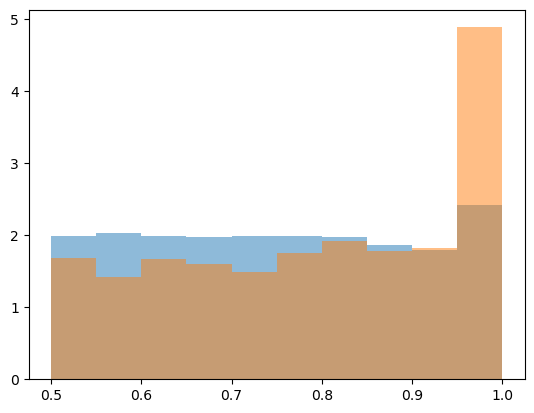

Fraction of no-motif peaks with OI = 1:
0.15308641975308643


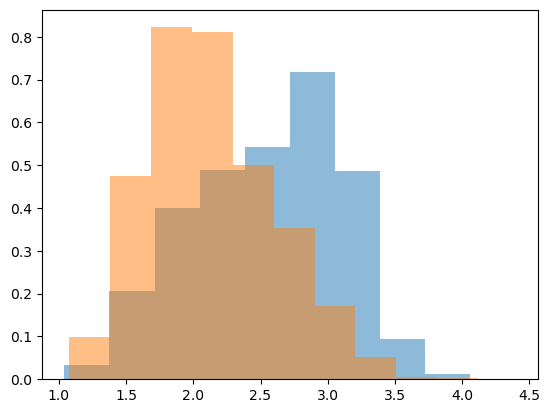

In [504]:
# Peaks with no motifs

print("Fraction of peaks with no motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) == 0) / motif_hit_counts["profile"].shape[0])


def get_orientation_indexes(profiles):
    return np.max(profiles.sum(axis=-1), axis=-1) / np.sum(profiles, axis=(-1,-2))

ois = get_orientation_indexes(true_profs)
peaks_no_motifs_ois = ois[motif_hit_counts["profile"].sum(axis=-1) == 0]

plt.hist(ois, density=True, alpha=0.5)
plt.hist(peaks_no_motifs_ois, density=True, alpha=0.5)
plt.show()

print("Fraction of no-motif peaks with OI = 1:")
print(np.sum(peaks_no_motifs_ois == 1) / peaks_no_motifs_ois.shape[0])


true_logcounts = np.log10(true_profs.sum(axis=(-1,-2)) + 1)
peaks_no_motifs_logcounts = true_logcounts[motif_hit_counts["profile"].sum(axis=-1) == 0]

plt.hist(true_logcounts, density=True, alpha=0.5)
plt.hist(peaks_no_motifs_logcounts, density=True, alpha=0.5)
plt.show()

In [644]:
from load_annotations_utils import load_annotations, does_a_overlap_anything_in_b

gene_regions_files = {"genes" : get_proj_dir() + "/annotations/gene_regions.bed",
                      "TSSs" : get_proj_dir() + "/annotations/TSSs.bed",
                      "promoters" : get_proj_dir() + "/annotations/promoters.bed",
                      "intergenic" : get_proj_dir() + "/annotations/intergenic_regions.bed",
                      "exons" : get_proj_dir() + "/annotations/exons.bed",
                      "introns" : get_proj_dir() + "/annotations/introns.bed",
                      "utrs" : get_proj_dir() + "/annotations/utrs.bed"}

def clean_coord_summits(coord):
    assert len(coord) >= 5, coord
    chrom, start, end, summit_pos, summit_neg = coord[:5]
    if summit_pos is None:
        summit_pos = summit_neg
    if summit_neg is None:
        summit_neg = summit_pos
    return (chrom, start, end, summit_pos, summit_neg)


def get_gene_region_overlap(coords, gene_regions_files, in_window=2114, out_window=1000):
    overlaps = dict()
    
    for region_name, region_filepath in gene_regions_files.items():
        regions = load_annotations(region_filepath, label=False)

        # get set of chromosomes included in peak set
        chroms = sorted(list(set(coord[0] for coord in coords)))

        # make dict of chromosome --> sorted list of regions
        regions_by_chrom = {chrom : sorted([c for c in regions if c[0] == chrom]) for chrom in chroms}
        
        overlap_bools = []
        for coord in coords:
            chrom, start, end, summit_pos, summit_neg = clean_coord_summits(coord)
            # adjust the starts and ends of peak coordinates so they only cover summits +/- 50 bp
            # (will probably get a lot of FP overlaps)
            coord_adjust = (chrom, min(summit_pos, summit_neg) - 50, max(summit_pos, summit_neg) + 50)

            overlap_bool = does_a_overlap_anything_in_b(coord_adjust, regions_by_chrom[chrom])
            overlap_bools.append(overlap_bool)
        
        overlaps[region_name] = np.array(overlap_bools)
        
    return overlaps

gene_region_annots = get_gene_region_overlap(coords, gene_regions_files)

In [645]:
# we will want to label regions as not-promoter anything, only if they aren't also a promoter

gene_region_names = list(gene_region_annots.keys())
for region in gene_region_names:
    if "promoters" in region or "TSSs" in region:
        continue
    if "_not_TSS" in region:  # this is here to avoid bugs if you re-run this cell again
        continue
        
    gene_region_annots[region + "_not_TSS"] = gene_region_annots[region] * (~ gene_region_annots["promoters"])

In [647]:
def load_annotations_with_strand(annot_bed):
    if annot_bed.endswith(".gz"):
        with gzip.open(annot_bed) as f:
            lines = [line.decode().split() for line in f]
    else:
        with open(annot_bed) as f:
            lines = [line.split() for line in f]

    coords = []
    for line in lines:
        chrom, start, end, strand = line[0], int(line[1]), int(line[2]), line[3]
        coords.append((chrom, start, end, strand))
    return coords


def get_dist_to_nearest_TSS(position, TSS_list):
    return 


def get_dist_to_TSS(coords, TSSs_bed, in_window=2114, out_window=1000):
    TSSs = load_annotations(TSSs_bed, label=False)

    # get set of chromosomes included in peak set
    chroms = sorted(list(set(coord[0] for coord in coords)))

    # make dict of chromosome --> sorted list of annotation regions
    TSSs_by_chrom = {chrom : np.array(sorted([t[1] for t in TSSs if t[0] == chrom])) for chrom in chroms}

    TSS_dists = []
    for coord in coords:
        chrom, _, _, summit_pos, summit_neg = clean_coord_summits(coord)
        summit_midpoint = (summit_pos + summit_neg) // 2

        dist_to_nearest_TSS = np.min(np.abs(TSSs_by_chrom[chrom] - summit_midpoint))
        TSS_dists.append(dist_to_nearest_TSS)

    return np.array(TSS_dists)


TSS_dists = get_dist_to_TSS(coords, gene_regions_files["TSSs"])

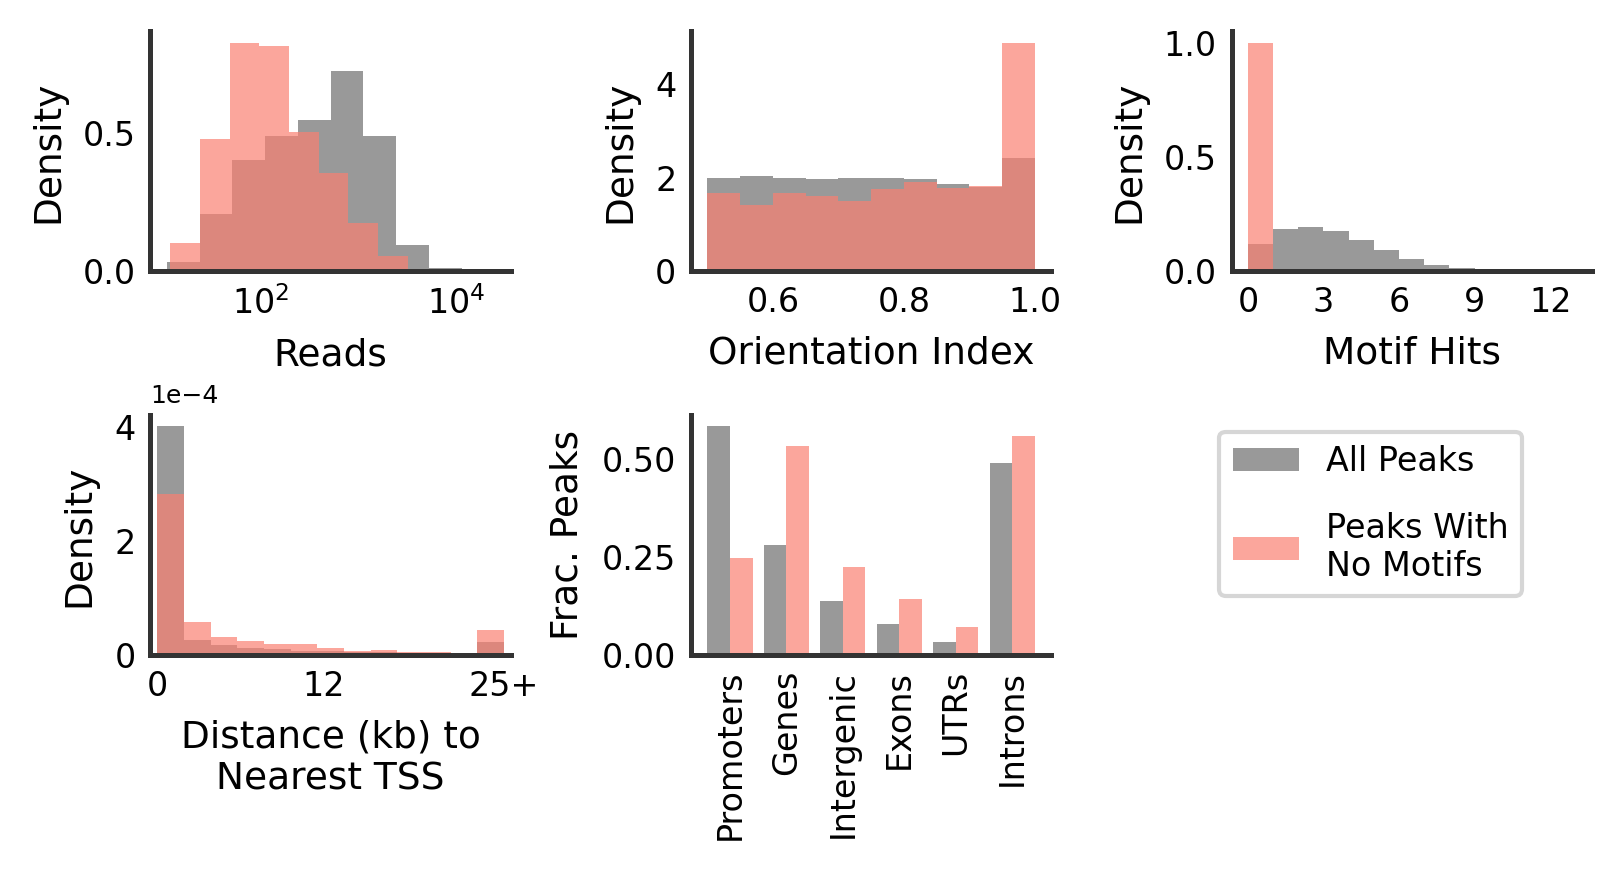

In [650]:
def make_ax_pretty(ax, linewidth=1.2, ax_color = "#333333", ticklabelsize=8):
    ax.spines["left"].set_linewidth(linewidth)
    ax.spines["bottom"].set_linewidth(linewidth)
    ax.spines["left"].set_color(ax_color)
    ax.spines["bottom"].set_color(ax_color)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    
    ax.tick_params(length=0, labelsize=ticklabelsize)
    

def make_plots_for_weird_sites(weird_site_indexes, true_profs, true_counts,
                               peak_hit_counts, gene_region_annots, TSS_dists):
    
    group_names = ["All Peaks", "Peaks With\nNo Motifs"]
    
    regions_to_labels = {"promoters" : "Promoters",
                        "genes" : "Genes",
                        "genes_not_TSS" : "Genes",
                        "exons" : "Exons",
                        "exons_not_TSS" : "Exons",
                        "intergenic" : "Intergenic",
                        "intergenic_not_TSS" : "Intergenic",
                        "utrs" : "UTRs",
                        "utrs_not_TSS" : "UTRs",
                        "introns" : "Introns"}
    regions_to_plot = ["promoters", "genes_not_TSS", "intergenic_not_TSS",
                       "exons_not_TSS", "utrs_not_TSS", "introns"]
    
    
    fig, axes = plt.subplots(2, 3, figsize=(6.2,2.7), dpi=300)
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    axes = axes.flatten()
    
    # Counts histogram
    
    log_all_true_counts = np.log10(true_counts + 1)
    log_weird_site_true_counts = np.log10(true_counts[weird_site_indexes] + 1)
    
    axes[0].hist(log_all_true_counts, alpha=0.8, density=True, color="gray")
    axes[0].hist(log_weird_site_true_counts, alpha=0.7, density=True, color="salmon")
    
    axes[0].set_xlabel("Reads", fontsize=9)
    axes[0].set_ylabel("Density", fontsize=9)
    
    xticks = [2,4]
    axes[0].set_xticks(xticks, [r'$10^{' + str(i) + r'}$' for i in xticks])
    
    # OI histogram
    
    ois = get_orientation_indexes(true_profs)
    
    axes[1].hist(ois,
                 alpha=0.8, density=True, color="gray")
    axes[1].hist(ois[weird_site_indexes],
                 alpha=0.7, density=True, color="salmon")
    
    axes[1].set_xlabel("Orientation Index", fontsize=9)
    axes[1].set_ylabel("Density", fontsize=9)
    
    # Motif hits histogram
    
    motif_hits = peak_hit_counts.sum(axis=1)
    axes[2].hist(motif_hits,
             bins=range(14), alpha=0.8, density=True, color="gray")
    axes[2].hist(motif_hits[weird_site_indexes],
             bins=range(14), alpha=0.7, density=True, color="salmon")
    
    axes[2].set_xlabel("Motif Hits", fontsize=9)
    axes[2].set_ylabel("Density", fontsize=9)
    
    axes[2].set_xticks(range(0,14,3))
    
    #for axis in axes:
    #    make_ax_pretty(axis)
    
    # disappear unused axis
    #axes[-1].remove()
    
    #plt.show()
    #return
    # TSS distances histogram

    stop_point = 25000
    num_bins = int(np.ceil(stop_point / 2000))
    axes[3].hist([min(d, stop_point) for d in TSS_dists if d is not None],
             density=True, bins=num_bins,
             alpha=0.8, color="gray")
    axes[3].hist([min(d, stop_point) for d in TSS_dists[weird_site_indexes] if d is not None],
             density=True, bins=num_bins,
             alpha=0.7, color="salmon")

    axes[3].set_xlim(-500, stop_point + 500)
    axes[3].set_xlabel("Distance (kb) to\nNearest TSS", fontsize=9)
    axes[3].set_ylabel("Density", fontsize=9)
    axes[3].ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
    axes[3].yaxis.offsetText.set_fontsize(6)
    
    middle_tick = int(stop_point / 2000) * 1000
    axes[3].set_xticks([0, middle_tick, stop_point],
                       ["0", middle_tick // 1000, str(stop_point // 1000) + "+"])
    
    # Gene annotation regions double bar plot

    fracs_overall = []
    fracs_in_region = []
    for region_name in regions_to_plot:
        region_bools = gene_region_annots[region_name]
        frac_overall = sum(region_bools) / len(region_bools)
        frac_in_region = sum(region_bools[weird_site_indexes]) / len(region_bools[weird_site_indexes])
        fracs_overall.append(frac_overall)
        fracs_in_region.append(frac_in_region)

    barplot_x_vals = np.arange(len(fracs_overall))
    bar_width = 0.4
    b1 = axes[4].bar(barplot_x_vals, fracs_overall,
                 width=bar_width, label=group_names[0], color="gray", alpha=0.8)
    # Same thing, but offset the x.
    b2 = axes[4].bar(barplot_x_vals + bar_width, fracs_in_region,
                 width=bar_width, label=group_names[1], color="salmon", alpha=0.7)

    # x axis ticks need to be offset to go under center of two bars
    axes[4].set_xticks(barplot_x_vals + bar_width / 2,
                       labels=[regions_to_labels[region_name] for region_name in regions_to_plot],
                       rotation=90, fontsize=6)
    axes[4].set_ylabel("Frac. Peaks", fontsize=9)

    # will function as legend for all subplots
    axes[4].legend(bbox_to_anchor=(1.42,1), loc="upper left",
               frameon=True, labelspacing=1, fontsize=8)
    
    
    # cosmetics for each subplot
    for axis in axes:
        make_ax_pretty(axis)
    
    # disappear unused axis
    axes[-1].remove()
    
    plt.show()
    
    
make_plots_for_weird_sites(np.where(motif_hit_counts["profile"].sum(axis=-1) == 0)[0],
                           true_profs, true_counts,
                               motif_hit_counts["profile"], gene_region_annots, TSS_dists)

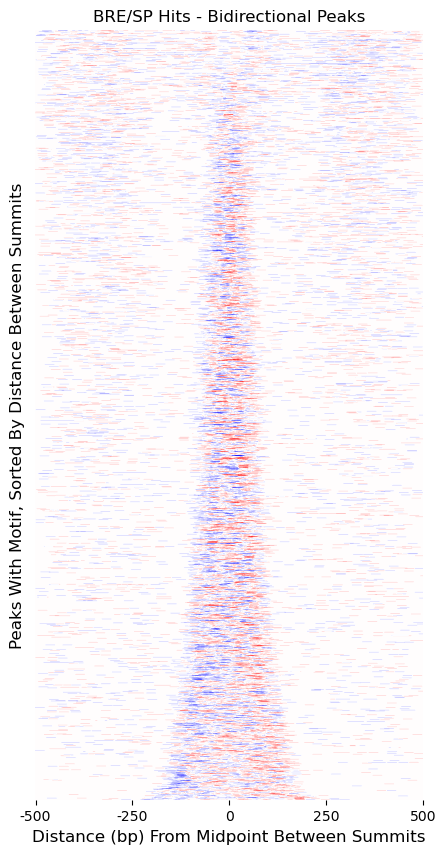

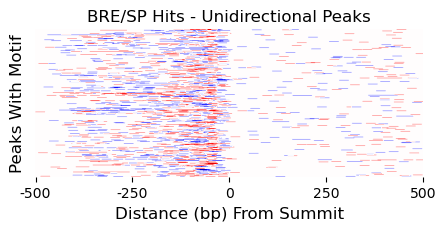

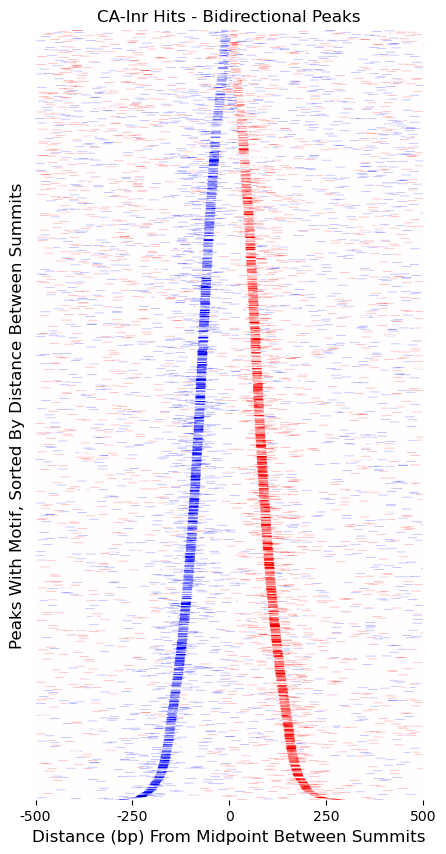

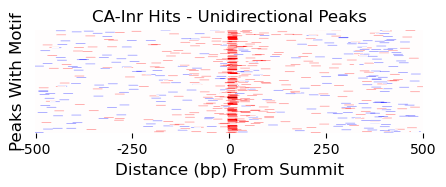

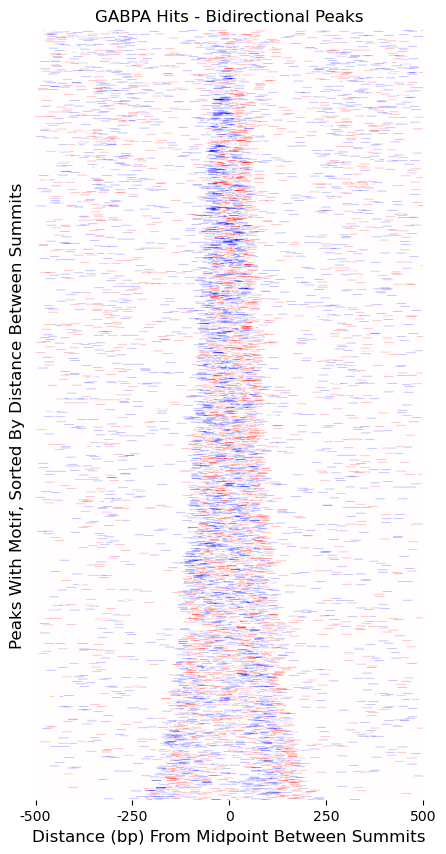

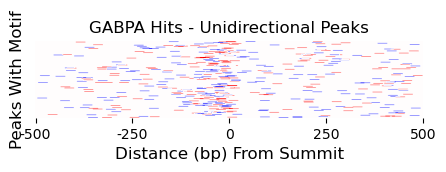

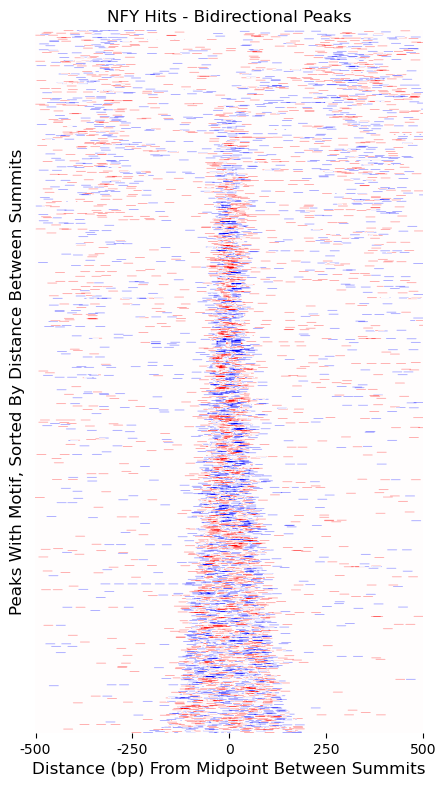

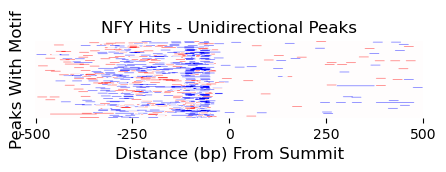

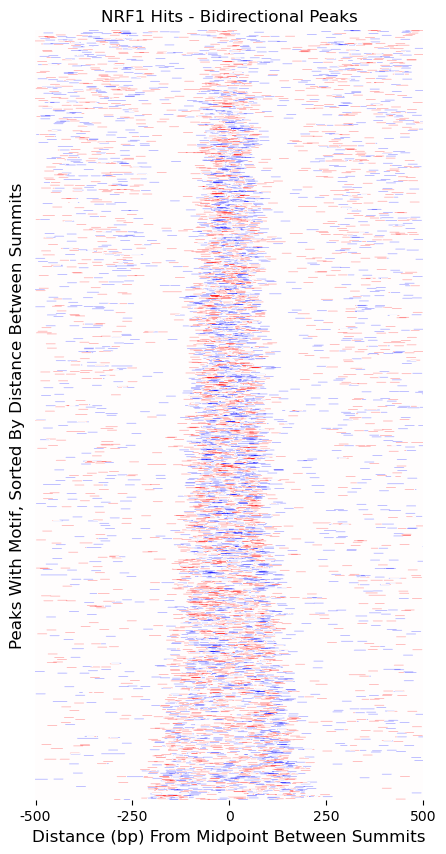

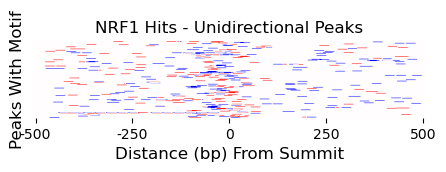

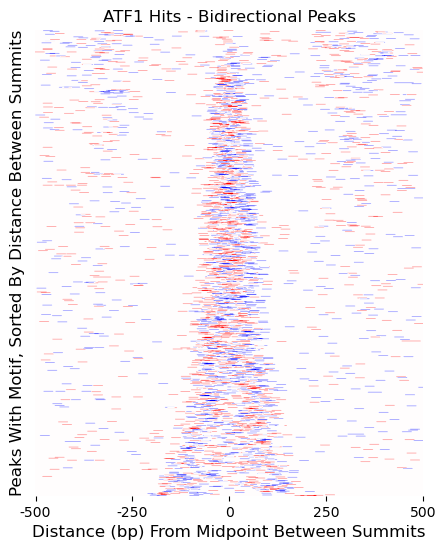

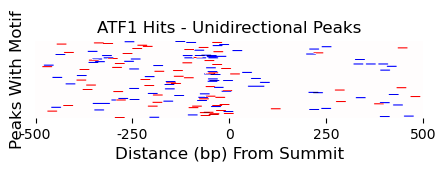

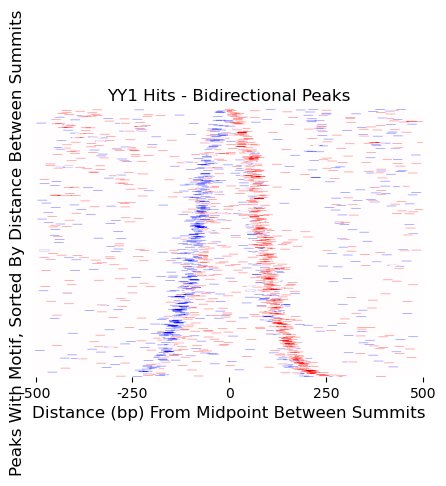

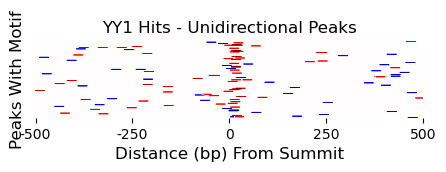

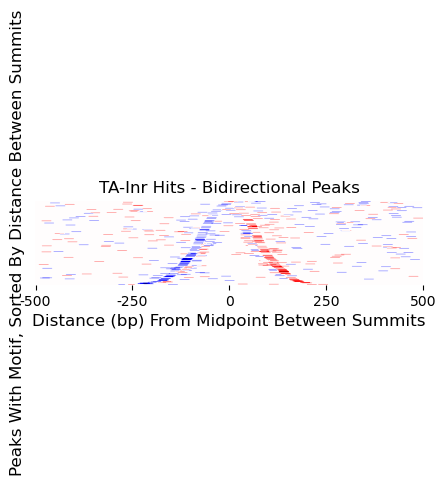

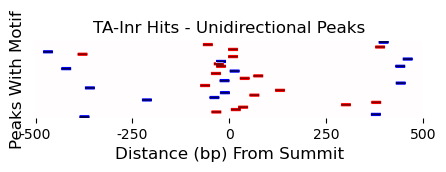

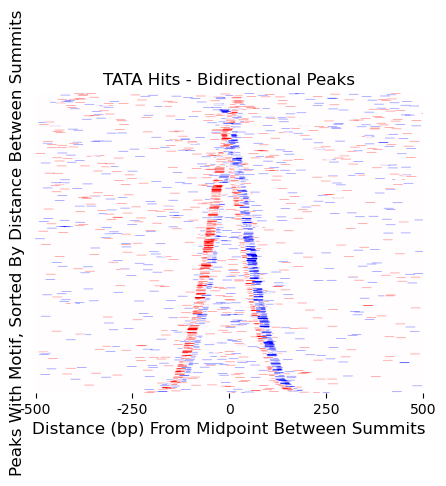

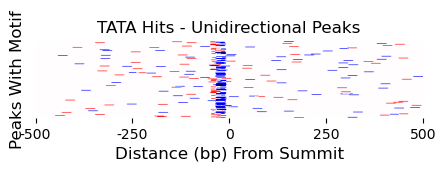

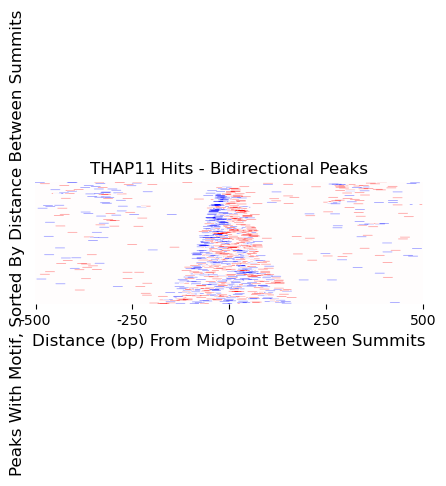

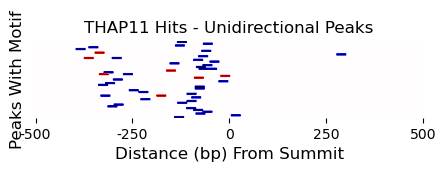

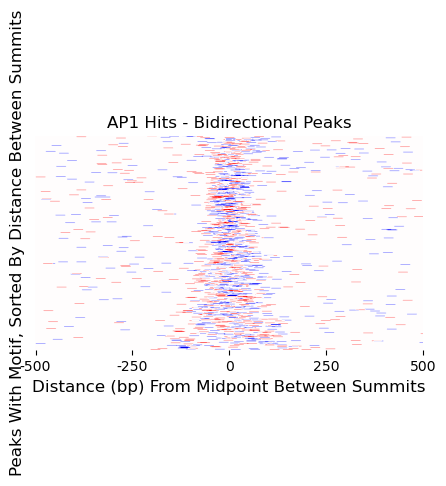

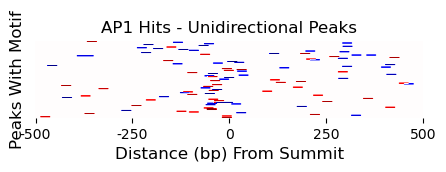

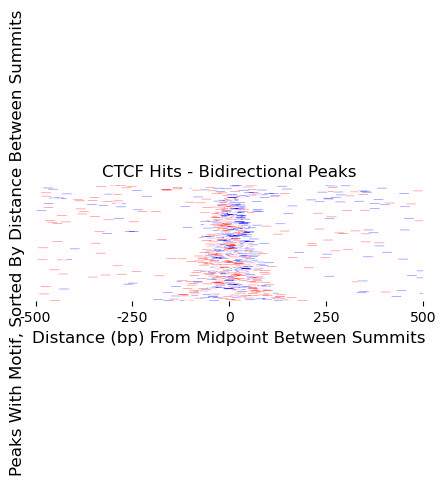

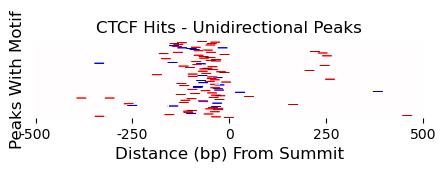

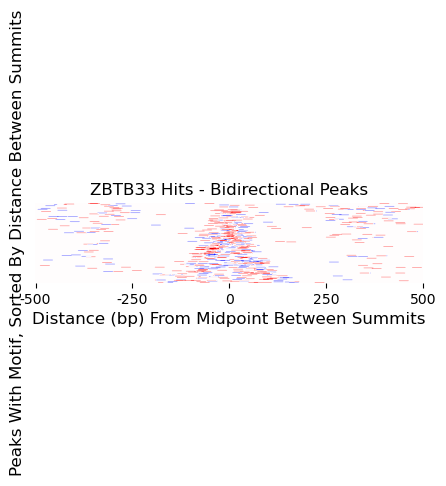

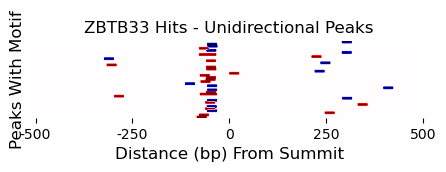

In [230]:
def convert_motif_start_to_prof_pos(peak_coords, motif_start, motif_end):
    peak_start, peak_end = peak_coords[1:3]
    real_start = motif_start - peak_start - (in_window - out_window) // 2
    return real_start, real_start + (motif_end - motif_start)


for motif_key in range(len(motif_keys_to_labels)):
    motif_hit_positions_across_peaks = defaultdict(lambda : [])
    
    peak_widths = []
    for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks["profile"]):
        hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["key"] == motif_key]

        peak_coords = coords[peak_index]
        peak_start = peak_coords[1]
        summit_pos, summit_neg = peak_coords[-2:]
        peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)
        
        if peak_is_unidirectional:
            if summit_pos is None:  # peak on - strand
                summit = summit_neg
            else:
                summit = summit_pos
        else:
            summit = (summit_pos + summit_neg) // 2
            
        summit_offset = summit - peak_start - in_window // 2
        
        if hits_of_this_motif.shape[0] > 0:
            motif_hit_positions = np.zeros((out_window,))

            for _, hit in hits_of_this_motif.iterrows():
                hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                     hit["start"],
                                                                     hit["end"])
                
                hit_start = hit_start - summit_offset
                hit_end = hit_end - summit_offset
                if hit["strand"] == "+":
                    motif_hit_positions[hit_start:hit_end] = 1
                else:
                    motif_hit_positions[hit_start:hit_end] = -1
                        

            if peak_is_unidirectional:
                if summit_pos is None:  # peak on - strand
                    motif_hit_positions = motif_hit_positions[::-1] * -1
                    
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
            
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                
                peak_widths.append(np.abs(summit_pos - summit_neg))
    
    motif_hit_positions_across_peaks["uni"] = np.array(motif_hit_positions_across_peaks["uni"])
    motif_hit_positions_across_peaks["bi"] = np.array(motif_hit_positions_across_peaks["bi"])
    
    motif_hit_positions_across_peaks["bi"] = motif_hit_positions_across_peaks["bi"][np.array(peak_widths).argsort()]
    
    
    for key, hit_positions in motif_hit_positions_across_peaks.items():
        plt.figure(figsize=(5, min(10, max(1, 0.002 * len(hit_positions)))))
        plt.imshow(hit_positions, aspect="auto", cmap="seismic")
        
        key_cap = key[0].upper() + key[1:]
        plt.title(motif_keys_to_labels[motif_key] + " Hits - " + key_cap + "directional Peaks")
        
        xticks = np.arange(0, out_window + 1, 250)
        plt.xticks(xticks, xticks - out_window // 2)
        
        
        if key == "bi":
            plt.ylabel("Peaks With Motif, Sorted By Distance Between Summits", fontsize=12)
            plt.xlabel("Distance (bp) From Midpoint Between Summits", fontsize=12)
        else:
            plt.ylabel("Peaks With Motif", fontsize=12)
            plt.xlabel("Distance (bp) From Summit", fontsize=12)
        
        plt.yticks([])
        for side in ["top", "right", "bottom", "left"]:
            plt.gca().spines[side].set_visible(False)
        plt.show()

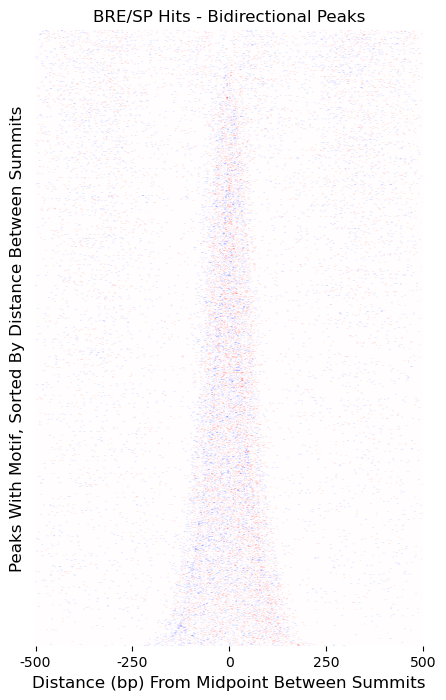

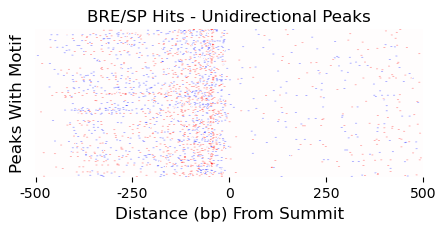

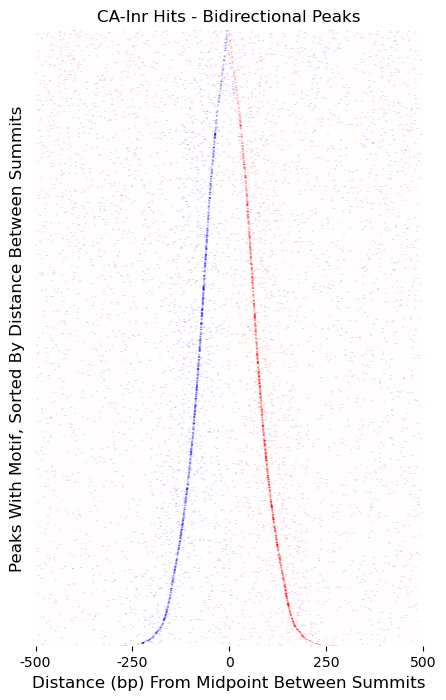

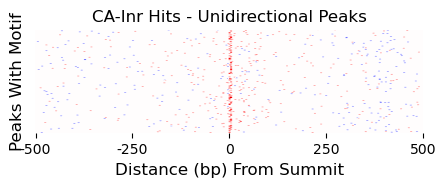

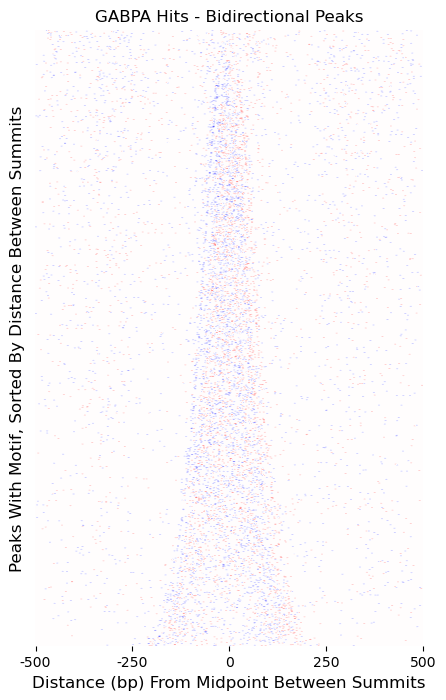

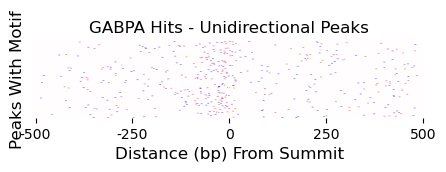

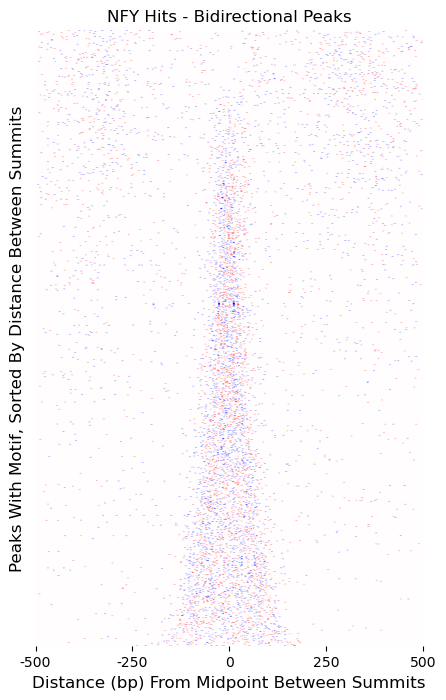

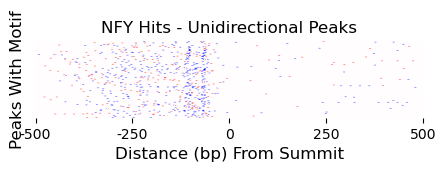

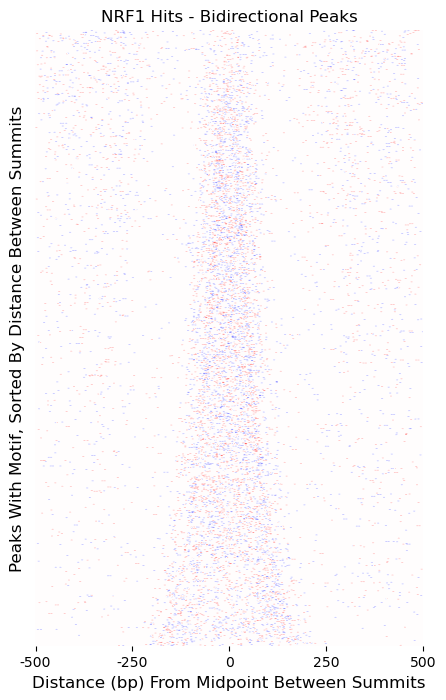

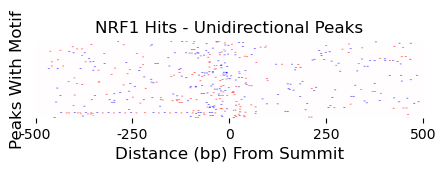

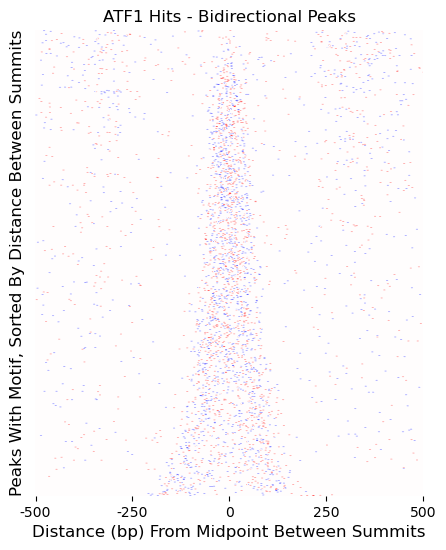

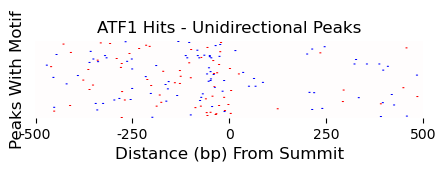

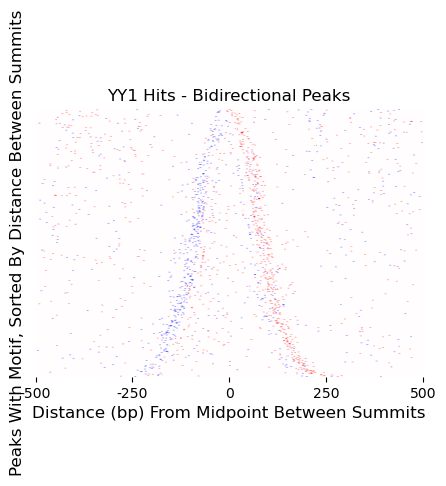

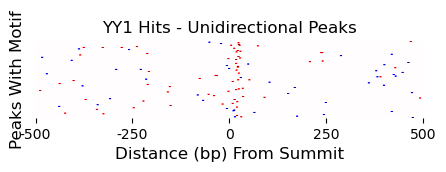

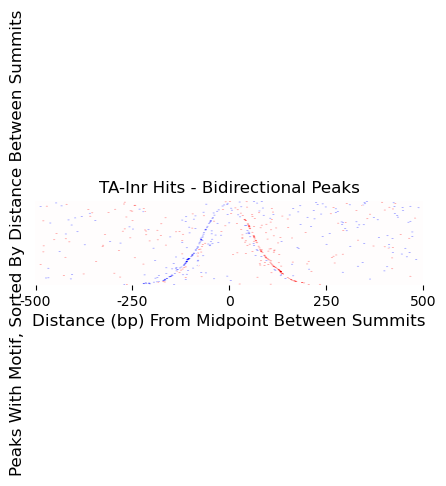

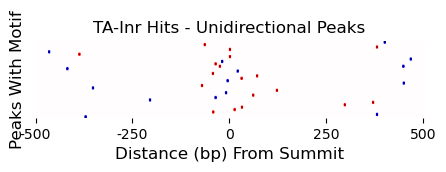

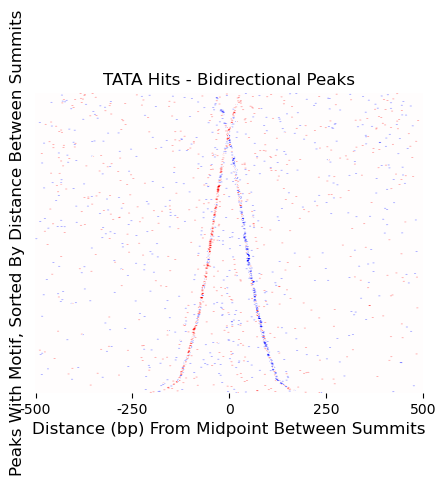

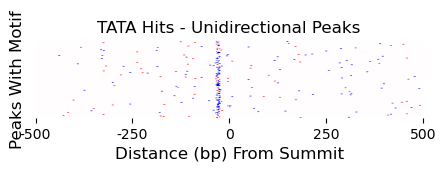

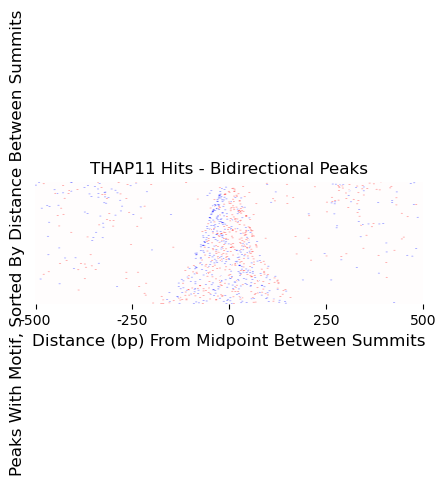

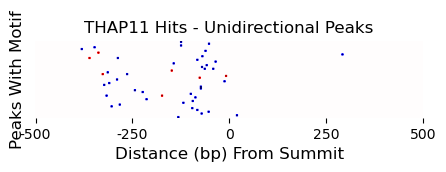

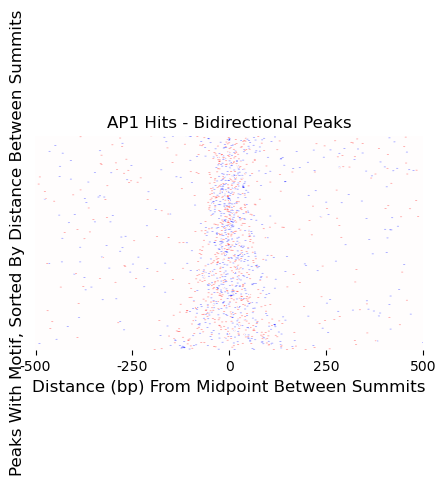

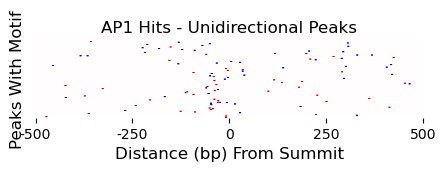

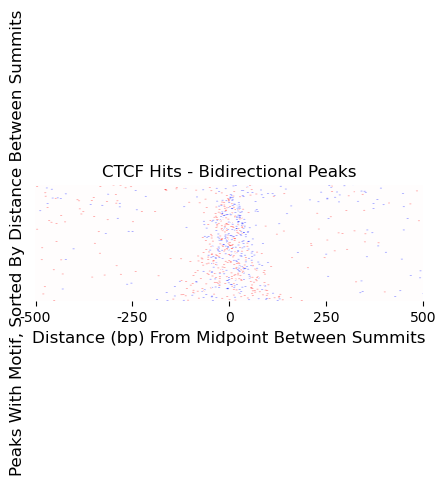

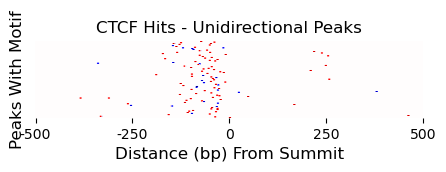

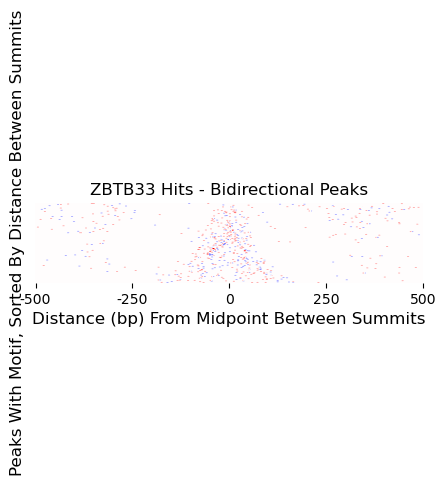

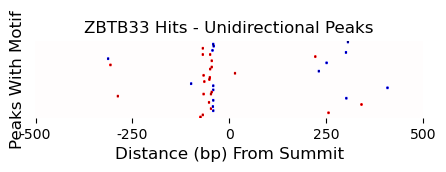

In [665]:
def convert_motif_start_to_prof_pos(peak_coords, motif_start, motif_end, motif_keys_to_centers = motif_keys_to_centers):
    peak_start, peak_end = peak_coords[1:3]
    real_start = motif_start - peak_start - (in_window - out_window) // 2
    return real_start, real_start + (motif_end - motif_start)


for motif_key in range(len(motif_keys_to_labels)):
    motif_center_offset = motif_keys_to_centers[motif_key]
    
    motif_hit_positions_across_peaks = defaultdict(lambda : [])
    
    peak_widths = []
    for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks["profile"]):
        hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["key"] == motif_key]

        peak_coords = coords[peak_index]
        peak_start = peak_coords[1]
        summit_pos, summit_neg = peak_coords[-2:]
        peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)
        
        if peak_is_unidirectional:
            if summit_pos is None:  # peak on - strand
                summit = summit_neg
            else:
                summit = summit_pos
        else:
            summit = (summit_pos + summit_neg) // 2
            
        summit_offset = summit - peak_start - in_window // 2
        
        if hits_of_this_motif.shape[0] > 0:
            motif_hit_positions = np.zeros((out_window,))

            for _, hit in hits_of_this_motif.iterrows():
                hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                     hit["start"],
                                                                     hit["end"])
                
                
                if hit["strand"] == "+":
                    stranded_center_offset = motif_center_offset
                else:
                    stranded_center_offset = (hit["end"] - hit["start"]) - motif_center_offset
                
                hit_start = hit_start + stranded_center_offset - summit_offset - 5
                hit_end = hit_start + 5
                
                if hit["strand"] == "+":
                    motif_hit_positions[hit_start:hit_end] = 1
                else:
                    motif_hit_positions[hit_start:hit_end] = -1
                        

            if peak_is_unidirectional:
                if summit_pos is None:  # peak on - strand
                    motif_hit_positions = motif_hit_positions[::-1] * -1
                    
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
            
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                
                peak_widths.append(np.abs(summit_pos - summit_neg))
    
    motif_hit_positions_across_peaks["uni"] = np.array(motif_hit_positions_across_peaks["uni"])
    motif_hit_positions_across_peaks["bi"] = np.array(motif_hit_positions_across_peaks["bi"])
    
    motif_hit_positions_across_peaks["bi"] = motif_hit_positions_across_peaks["bi"][np.array(peak_widths).argsort()]
    
    
    for key, hit_positions in motif_hit_positions_across_peaks.items():
        plt.figure(figsize=(5, min(8, max(1, 0.002 * len(hit_positions)))))
        plt.imshow(hit_positions, aspect="auto", cmap="seismic")
        
        key_cap = key[0].upper() + key[1:]
        plt.title(motif_keys_to_labels[motif_key] + " Hits - " + key_cap + "directional Peaks")
        
        xticks = np.arange(0, out_window + 1, 250)
        plt.xticks(xticks, xticks - out_window // 2)
        
        
        if key == "bi":
            plt.ylabel("Peaks With Motif, Sorted By Distance Between Summits", fontsize=12)
            plt.xlabel("Distance (bp) From Midpoint Between Summits", fontsize=12)
        else:
            plt.ylabel("Peaks With Motif", fontsize=12)
            plt.xlabel("Distance (bp) From Summit", fontsize=12)
        
        plt.yticks([])
        for side in ["top", "right", "bottom", "left"]:
            plt.gca().spines[side].set_visible(False)
        plt.show()

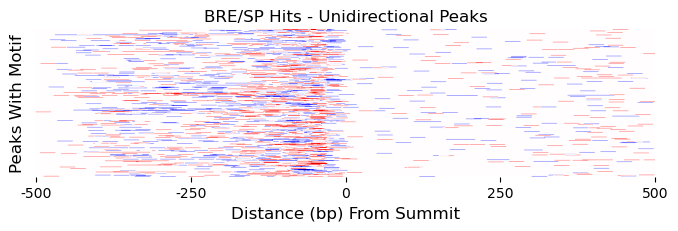

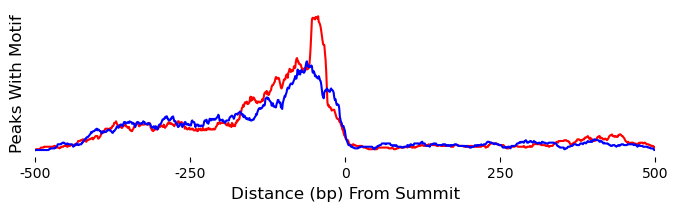

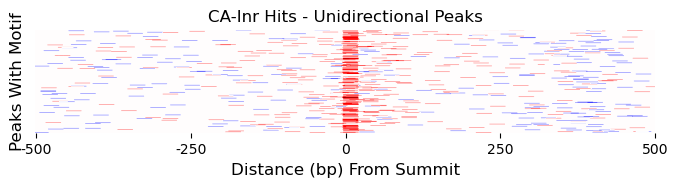

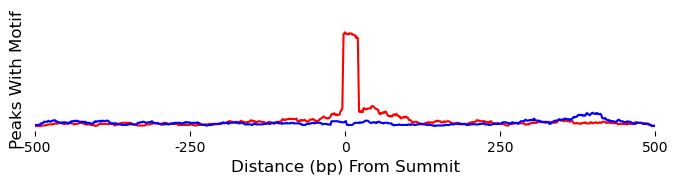

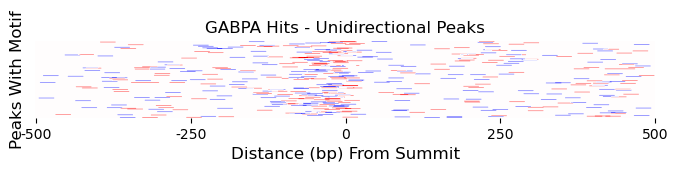

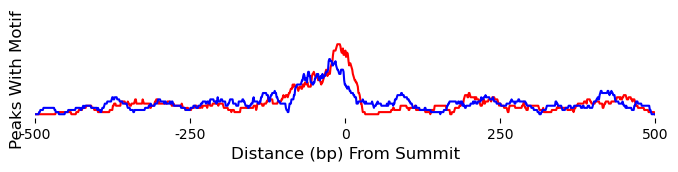

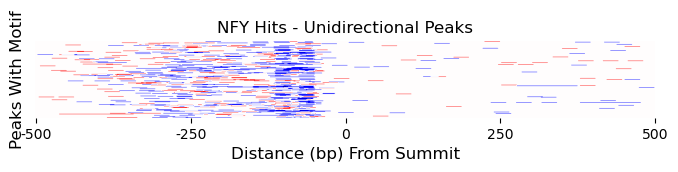

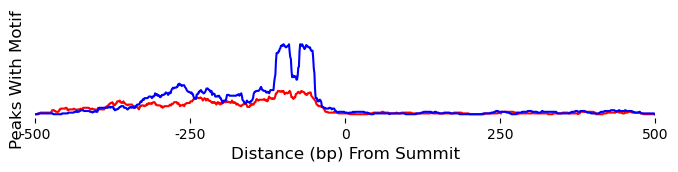

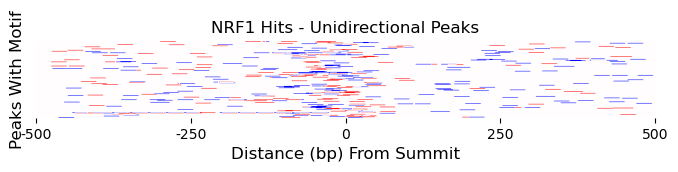

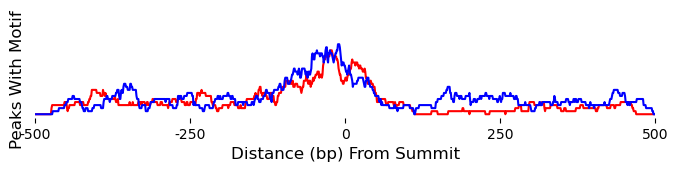

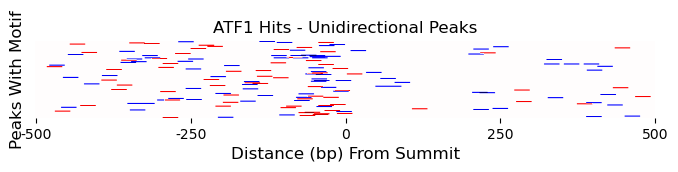

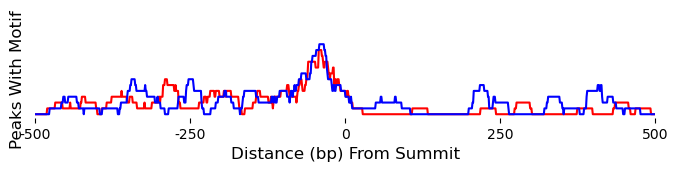

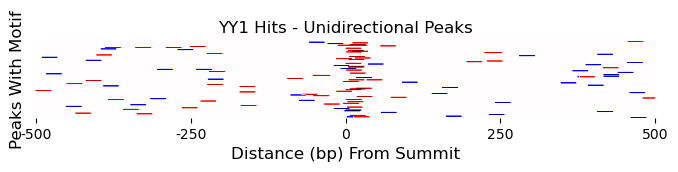

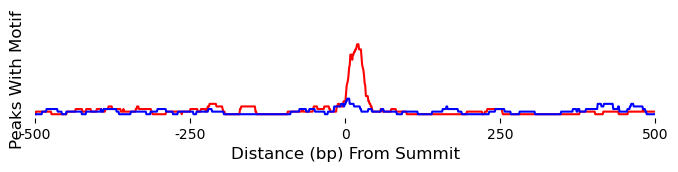

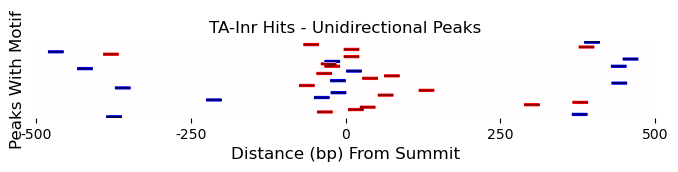

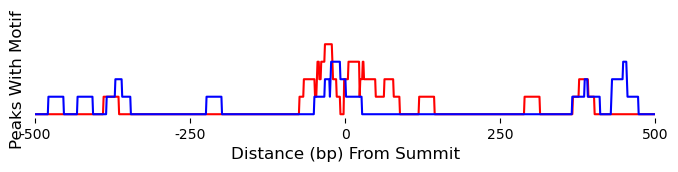

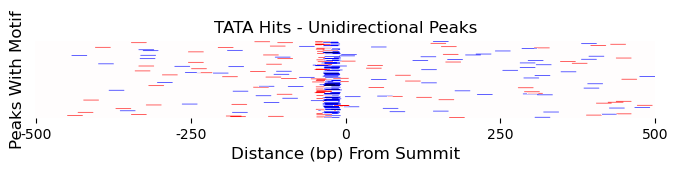

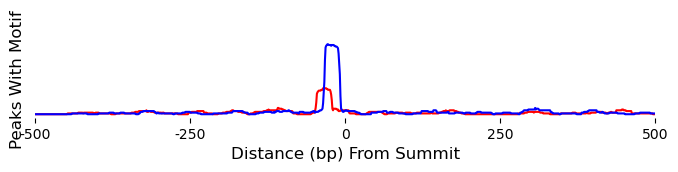

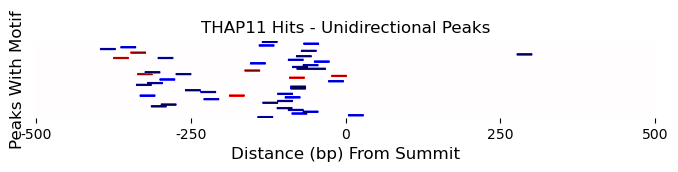

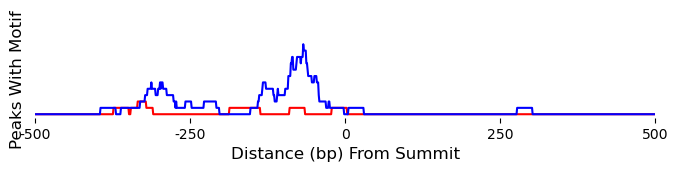

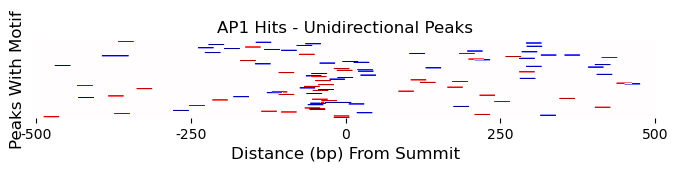

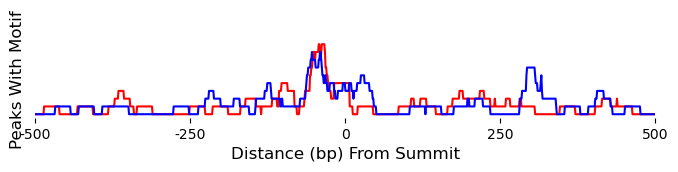

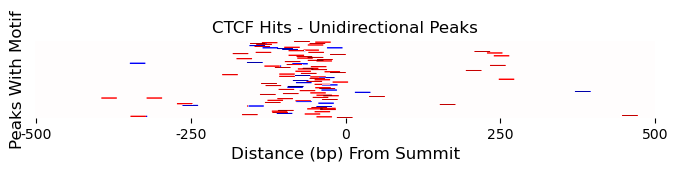

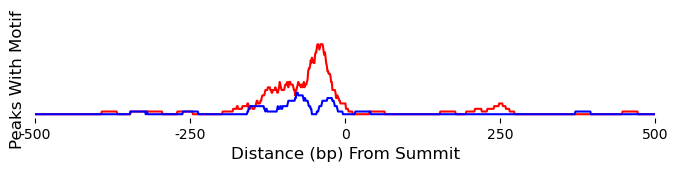

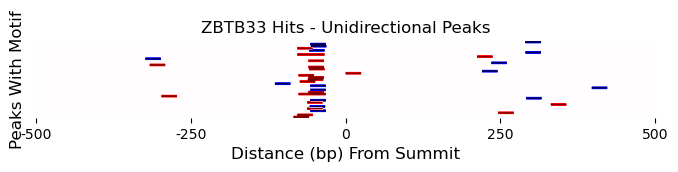

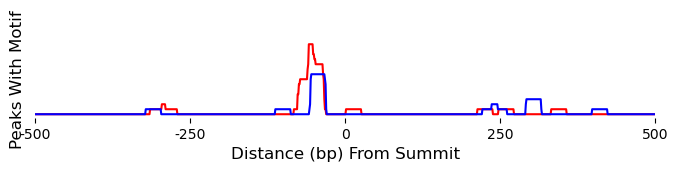

In [240]:
def plot_uni_motif_distributions(motif_hits_peaks, motif_keys_to_labels, coords):
    for motif_key in range(len(motif_keys_to_labels)):
        motif_hit_positions_across_peaks = []

        peak_widths = []
        for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks):
            hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["key"] == motif_key]

            peak_coords = coords[peak_index]
            peak_start = peak_coords[1]
            summit_pos, summit_neg = peak_coords[-2:]
            peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)

            if not peak_is_unidirectional:
                continue
                
            if summit_pos is None:  # peak on - strand
                summit = summit_neg
            else:
                summit = summit_pos

            summit_offset = summit - peak_start - in_window // 2

            if hits_of_this_motif.shape[0] > 0:
                motif_hit_positions = np.zeros((out_window,))

                for _, hit in hits_of_this_motif.iterrows():
                    hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                         hit["start"],
                                                                         hit["end"])

                    hit_start = hit_start - summit_offset
                    hit_end = hit_end - summit_offset
                    if hit["strand"] == "+":
                        motif_hit_positions[hit_start:hit_end] = 1
                    else:
                        motif_hit_positions[hit_start:hit_end] = -1

                if summit_pos is None:  # peak on - strand
                    motif_hit_positions = motif_hit_positions[::-1] * -1

                motif_hit_positions_across_peaks.append(motif_hit_positions)

        motif_hit_positions_across_peaks = np.array(motif_hit_positions_across_peaks)

        plt.figure(figsize=(8, min(10, max(1, 0.002 * len(motif_hit_positions_across_peaks)))))
        plt.imshow(motif_hit_positions_across_peaks, aspect="auto", cmap="seismic")

        key_cap = key[0].upper() + key[1:]
        plt.title(motif_keys_to_labels[motif_key] + " Hits - Unidirectional Peaks")

        xticks = np.arange(0, out_window + 1, 250)
        plt.xticks(xticks, xticks - out_window // 2)


        plt.ylabel("Peaks With Motif", fontsize=12)
        plt.xlabel("Distance (bp) From Summit", fontsize=12)

        plt.yticks([])
        for side in ["top", "right", "bottom", "left"]:
            plt.gca().spines[side].set_visible(False)
        plt.show()
        
        
        pos_hit_positions = motif_hit_positions_across_peaks == 1
        neg_hit_positions = motif_hit_positions_across_peaks == -1
        
        pos_hits_agg = pos_hit_positions.sum(axis=0)
        neg_hits_agg = neg_hit_positions.sum(axis=0)
        
        plt.figure(figsize=(8, max(1, 0.002 * len(motif_hit_positions_across_peaks))))
        plt.plot(range(len(pos_hits_agg)), pos_hits_agg, c="r")
        plt.plot(range(len(neg_hits_agg)), neg_hits_agg, c="b")
        
        for side in ["top", "right", "bottom", "left"]:
            plt.gca().spines[side].set_visible(False)
            
        plt.xticks(xticks, xticks - out_window // 2)
        plt.xlim(xticks[0], xticks[-1])
        plt.yticks([])
        
        plt.xlabel("Distance (bp) From Summit", fontsize=12)
        plt.ylabel("Peaks With Motif", fontsize=12)
        
        plt.show()
        

plot_uni_motif_distributions(motif_hits_peaks["profile"], motif_keys_to_labels, coords)

In [ ]:
def plot_uni_motif_distributions(motif_hits_peaks, motif_keys_to_labels, coords, motif_keys_to_centers):
    
    all_motif_hit_positions = []
    
    for motif_key in range(len(motif_keys_to_labels)):
        motif_center_offset = motif_keys_to_centers[motif_key]
        
        motif_hit_positions_across_peaks = []

        peak_widths = []
        for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks):
            hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["key"] == motif_key]

            peak_coords = coords[peak_index]
            peak_start = peak_coords[1]
            summit_pos, summit_neg = peak_coords[-2:]
            peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)

            if not peak_is_unidirectional:
                continue
                
            if summit_pos is None:  # peak on - strand
                summit = summit_neg
            else:
                summit = summit_pos

            summit_offset = summit - peak_start - in_window // 2

            if hits_of_this_motif.shape[0] > 0:
                motif_hit_positions = np.zeros((out_window,))

                for _, hit in hits_of_this_motif.iterrows():
                    hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                         hit["start"],
                                                                         hit["end"])

                    hit_start = hit_start - summit_offset
                    hit_end = hit_end - summit_offset
                    
                    if hit["strand"] == "+":
                        stranded_center_offset = motif_center_offset
                    else:
                        stranded_center_offset = (hit["end"] - hit["start"]) - motif_center_offset
                    
                    hit_pos = hit["start"] + stranded_center_offset - summit_offset
                    
                    if hit["strand"] == "+":
                        motif_hit_positions[hit_pos:hit_pos+1] = 1
                    else:
                        motif_hit_positions[hit_pos:hit_pos+1] = -1

                if summit_pos is None:  # peak on - strand
                    motif_hit_positions = motif_hit_positions[::-1] * -1

                motif_hit_positions_across_peaks.append(motif_hit_positions)

        all_motif_hit_positions.append(motif_hit_positions_across_peaks)

        
        

plot_uni_motif_distributions(motif_hits_peaks["profile"], motif_keys_to_labels, coords, motif_keys_to_centers)

In [252]:
def get_motif_centers_from_cwms(modisco_results, patterns_to_keep):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    motif_keys_to_centers = dict()
    for motif_key, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        cwm = pattern["contrib_scores"][:]
        
        motif_center = np.argmax(cwm.sum(axis=-1))
        motif_keys_to_centers[motif_key] = motif_center
        
    return motif_keys_to_centers

motif_keys_to_centers = get_motif_centers_from_cwms(modisco_results, patterns_to_keep)

In [495]:
def get_uni_motif_distributions(motif_hits_peaks, coords, motif_keys_to_centers):
    all_motif_positions = defaultdict(lambda : [])
    
    for motif_key in range(len(motif_keys_to_centers)):
        motif_center_offset = motif_keys_to_centers[motif_key]
        
        motif_hit_positions_across_peaks = defaultdict(lambda : [])

        peak_widths = []
        for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks):
            hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["key"] == motif_key]

            peak_coords = coords[peak_index]
            peak_start = peak_coords[1]
            summit_pos, summit_neg = peak_coords[-2:]
            
            peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)

            if not peak_is_unidirectional:
                continue
                
            if summit_pos is not None:  # peak is on + strand
                summit = summit_pos
            else:
                summit = summit_neg
            
            #summit_offset = summit - peak_start - in_window // 2

            if hits_of_this_motif.shape[0] > 0:
                motif_pos_hit_positions = []
                motif_neg_hit_positions = []

                for _, hit in hits_of_this_motif.iterrows():
                    hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                         hit["start"],
                                                                         hit["end"])

                    if hit["strand"] == "+":
                        stranded_center_offset = motif_center_offset
                    else:
                        stranded_center_offset = (hit["end"] - hit["start"]) - motif_center_offset
                    
                    hit_position = hit["start"] + stranded_center_offset - summit

                    if summit_pos is None:  # flip the motif position about the summit 
                        hit_position = -1 * hit_position
                    
                    if hit["strand"] == "+":
                        if summit_pos is not None:
                            motif_pos_hit_positions.append(hit_position)
                        else:
                            motif_neg_hit_positions.append(hit_position)
                    else:
                        if summit_pos is not None:
                            motif_neg_hit_positions.append(hit_position)
                        else:
                            motif_pos_hit_positions.append(hit_position)

                motif_hit_positions_across_peaks["pos"].extend(motif_pos_hit_positions)
                motif_hit_positions_across_peaks["neg"].extend(motif_neg_hit_positions)

        hit_positions_pos = np.array(motif_hit_positions_across_peaks["pos"])
        hit_positions_neg = np.array(motif_hit_positions_across_peaks["neg"])
        hit_positions_total = np.concatenate((hit_positions_pos, hit_positions_neg))
        
        bins = np.arange(-300, 100, 10)
        if len(hit_positions_pos) > 15:
            hit_dist_pos, _ = np.histogram(hit_positions_pos, bins=bins, density=True)
        else:
            hit_dist_pos = np.zeros((len(bins)-1,))
            
        if len(hit_positions_neg) > 15:
            hit_dist_neg, _ = np.histogram(hit_positions_neg, bins=bins, density=True)
        else:
            hit_dist_neg = np.zeros((len(bins)-1,))
            
        if len(hit_positions_total) > 15:
            hit_dist_total, _ = np.histogram(hit_positions_total, bins=bins, density=True)
        else:
            hit_dist_total = np.zeros((len(bins)-1,))

        all_motif_positions["pos"].append(hit_dist_pos)
        all_motif_positions["neg"].append(hit_dist_neg)
        all_motif_positions["total"].append(hit_dist_total)
    
    all_motif_positions["pos"] = np.array(all_motif_positions["pos"])
    all_motif_positions["neg"] = np.array(all_motif_positions["neg"])
    all_motif_positions["total"] = np.array(all_motif_positions["total"])
    return all_motif_positions
        

uni_motif_distributions = get_uni_motif_distributions(motif_hits_peaks["profile"],
                                                      coords, motif_keys_to_centers)

pos


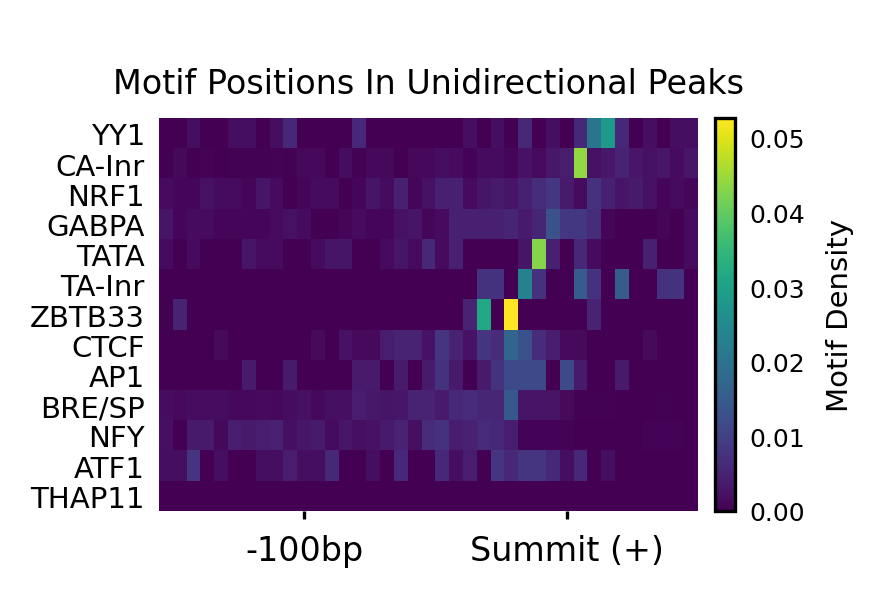

neg


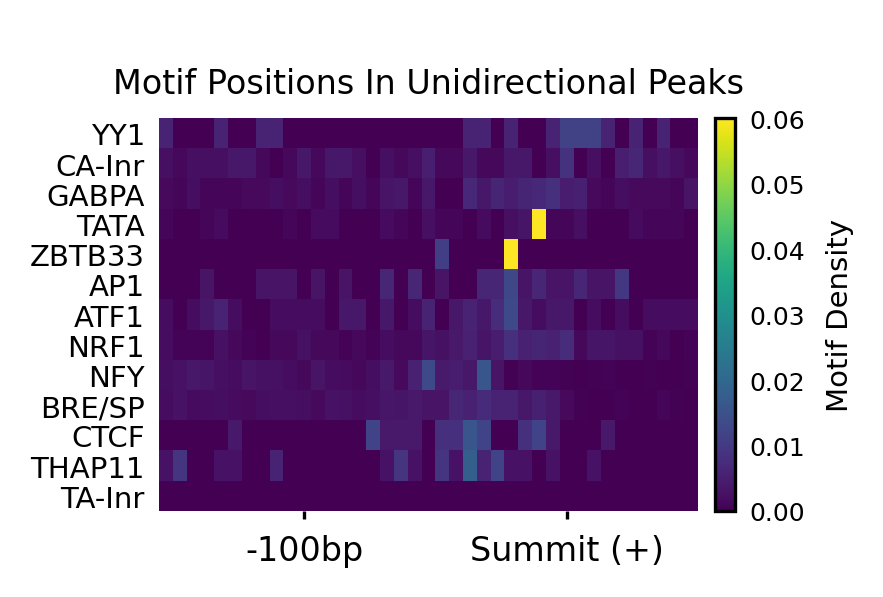

total


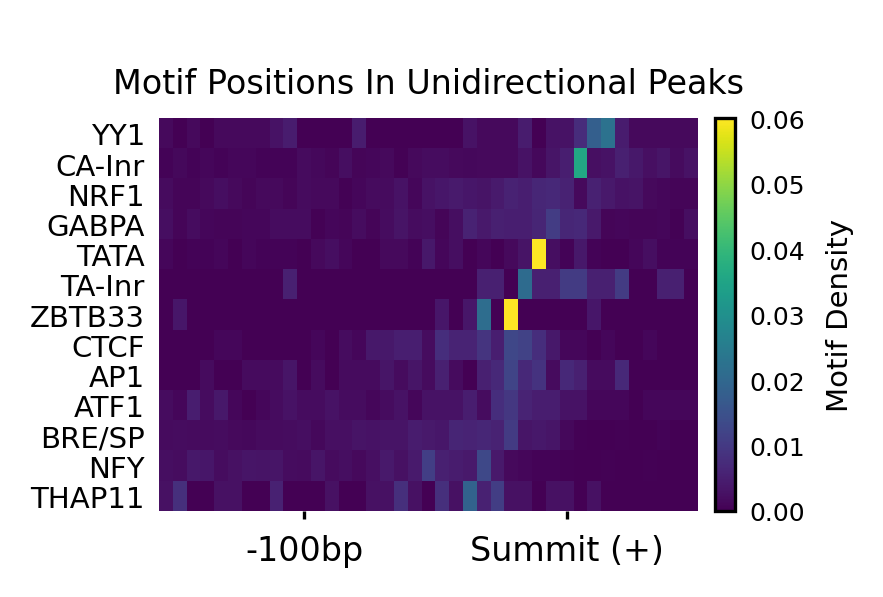

In [496]:
def plot_uni_motif_distribution_heatmaps(stranded_motif_positions, 
                                       motif_keys_to_labels = motif_keys_to_labels):
    
    for strand, motif_distributions in stranded_motif_positions.items():
        print(strand)
        # this ordering is completely arbitrary
        num_bins = motif_distributions.shape[1]
        dist_from_center_bin = np.sqrt(np.abs(np.arange(0, num_bins) - num_bins * 0.75 ))
        motif_order = np.argsort(np.argmax(motif_distributions, axis=1))[::-1]

        clip_to = 0.06
        motif_distributions = np.clip(motif_distributions, 0, clip_to)

        plt.figure(figsize=(2.5, 1.7), dpi=300)

        plt.imshow(motif_distributions[motif_order], aspect="auto")

        plt.yticks(range(len(motif_keys_to_labels)), np.array(motif_keys_to_labels)[motif_order], fontsize=7)
        plt.tick_params("y", length=0)
        plt.tick_params("x", length=2)

        plt.title("\nMotif Positions In Unidirectional Peaks", fontsize=8)

        plt.xticks([np.round(num_bins * frac) for frac in [0.25, 0.75]],
                   ["-100bp", "Summit (+)"], fontsize=8)
        
        ax = plt.gca()
        for side in ["top", "right", "bottom", "left"]:
            ax.spines[side].set_visible(False)

        #cbar_ticks = range(0, clip_to + 1)
        #cbar = plt.colorbar(ticks=cbar_ticks, fraction=0.044, pad=0.03)
        cbar = plt.colorbar(fraction=0.044, pad=0.03)
        cbar.ax.tick_params(labelsize=6, length=0)
        cbar.set_label(label="Motif Density", size=7, labelpad=5)
        #cbar.ax.set_yticklabels([str(i) for i in cbar_ticks[:-1]] + [str(clip_to) + "+"])
        plt.show()
        

plot_uni_motif_distribution_heatmaps(uni_motif_distributions)

In [433]:
def get_bidirectional_peak_motif_distributions(motif_hits_peaks, coords, motif_keys_to_centers):
    
    motif_distributions = []
    
    for motif_key in range(len(motif_keys_to_centers)):
        motif_center_offset = motif_keys_to_centers[motif_key]
        
        motif_hit_positions_across_peaks = defaultdict(lambda : [])

        peak_widths = []
        for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks):
            hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["key"] == motif_key]

            peak_coords = coords[peak_index]
            peak_start = peak_coords[1]
            summit_pos, summit_neg = peak_coords[-2:]
            
            peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)

            if peak_is_unidirectional:
                continue
            
            peak_width = np.abs(summit_pos - summit_neg)
            if peak_width < 50:
                continue
                
            summit_offset = summit_neg - peak_start - in_window // 2

            if hits_of_this_motif.shape[0] > 0:
                motif_pos_hit_positions = []
                motif_neg_hit_positions = []

                for _, hit in hits_of_this_motif.iterrows():
                    hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                         hit["start"],
                                                                         hit["end"])

                    if hit["strand"] == "+":
                        stranded_center_offset = motif_center_offset
                    else:
                        stranded_center_offset = (hit["end"] - hit["start"]) - motif_center_offset
                    
                    hit_position_norm = (hit["start"] + stranded_center_offset - summit_neg) / peak_width
                    
                    if hit_position_norm < -0.5 or hit_position_norm > 1.5:
                        continue
                    
                    if hit["strand"] == "+":
                        motif_pos_hit_positions.append(hit_position_norm)
                    else:
                        motif_neg_hit_positions.append(hit_position_norm)

                motif_hit_positions_across_peaks["pos"].extend(motif_pos_hit_positions)
                motif_hit_positions_across_peaks["neg"].extend(motif_neg_hit_positions)
                peak_widths.append(peak_width)

        motif_hit_positions_across_peaks["pos"] = np.array(motif_hit_positions_across_peaks["pos"])
        motif_hit_positions_across_peaks["neg"] = np.array(motif_hit_positions_across_peaks["neg"])
        motif_hit_positions_across_peaks["total"] = np.concatenate((motif_hit_positions_across_peaks["pos"],
                                                                    motif_hit_positions_across_peaks["neg"]))
        
        # compute histogram of motif hits to get hit counts per position (binned)

        bins = np.arange(-0.5, 1.5, 1 / 25)
        total_hist, _ = np.histogram(motif_hit_positions_across_peaks["total"],
                                     bins=bins, density=True)
        motif_distributions.append(total_hist)
        
    motif_distributions = np.array(motif_distributions)
    return motif_distributions


motif_distributions = get_bidirectional_peak_motif_distributions(motif_hits_peaks["profile"],
                                                                coords, motif_keys_to_centers)

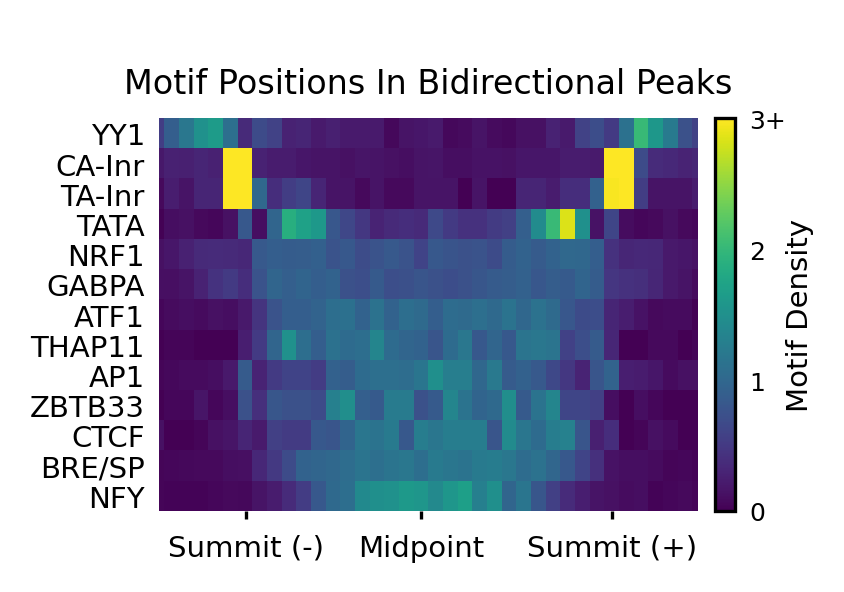

In [448]:
def plot_bi_motif_distribution_heatmap(motif_distributions, 
                                       motif_keys_to_labels = motif_keys_to_labels):
    
    # NOTE: this function assumes you didn't change the bins used in 
    # get_bidirectional_peak_motif_distributions()
    
    # also this ordering is completely arbitrary
    num_bins = motif_distributions.shape[1]
    dist_from_center_bin = np.sqrt(np.abs(np.arange(0, num_bins) - num_bins / 2))
    motif_order = np.argsort(np.dot(dist_from_center_bin, motif_distributions.T))[::-1]
    
    clip_to = 3
    motif_distributions = np.clip(motif_distributions, 0, clip_to)
    #motif_distributions = motif_distributions / motif_distributions.max(axis=1, keepdims=True)
    
    plt.figure(figsize=(2.5, 1.7), dpi=300)
    
    plt.imshow(motif_distributions[motif_order], aspect="auto")
    
    plt.yticks(range(len(motif_keys_to_labels)), np.array(motif_keys_to_labels)[motif_order], fontsize=7)
    plt.tick_params("y", length=0)
    plt.tick_params("x", length=2)
    
    plt.title("\nMotif Positions In Bidirectional Peaks", fontsize=8)
        
    ax = plt.gca()
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    xticks = [np.round(num_bins * frac) for frac in [0.25, 0.5, 0.75]]

    plt.xticks(xticks,
               ["Summit (-)", "Midpoint", "Summit (+)"],
               fontsize=7)

    plt.xlim(num_bins * 0.125, num_bins * 0.875)
    cbar_ticks = range(0, clip_to + 1)
    cbar = plt.colorbar(ticks=cbar_ticks, fraction=0.044, pad=0.03)
    #cbar = plt.colorbar(fraction=0.044, pad=0.03)
    cbar.ax.tick_params(labelsize=6, length=0)
    cbar.set_label(label="Motif Density", size=7, labelpad=0)
    cbar.ax.set_yticklabels([str(i) for i in cbar_ticks[:-1]] + [str(clip_to) + "+"])
    plt.show()
        

plot_bi_motif_distribution_heatmap(motif_distributions)

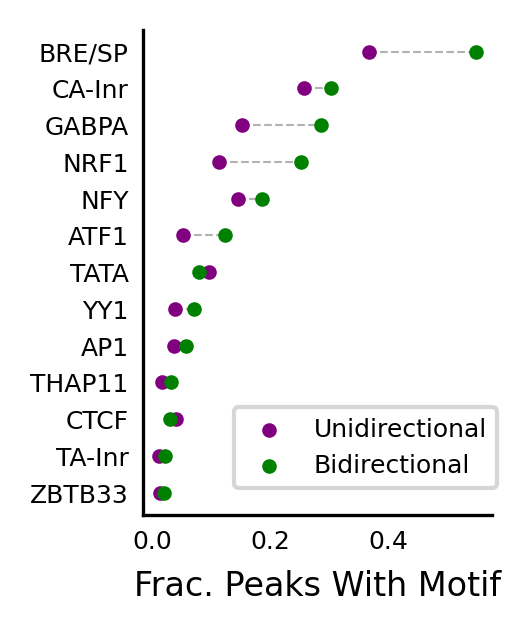

In [548]:
def plot_motif_presence_by_peak_type(motif_hit_counts, coords, motif_keys_to_labels = motif_keys_to_labels):
    
    summits_pos, summits_neg = zip(*[coord[3:5] for coord in coords])
    peak_is_unidirectional = np.array([summits_pos[i] is None or summits_neg[i] is None for i in range(len(coords))])

    motif_hit_bools = motif_hit_counts > 0
    
    uni_motif_hit_bools = motif_hit_bools[peak_is_unidirectional]
    uni_motif_counts = uni_motif_hit_bools.sum(axis=0)
    uni_motif_fracs = uni_motif_counts / np.sum(peak_is_unidirectional)
        
    bi_motif_hit_bools = motif_hit_bools[~ peak_is_unidirectional]
    bi_motif_counts = bi_motif_hit_bools.sum(axis=0)
    bi_motif_fracs = bi_motif_counts / np.sum(~ peak_is_unidirectional)
        
    plot_order = np.argsort(bi_motif_fracs)[::-1]
    #uni_motif_fracs = uni_motif_fracs[plot_order]
    #bi_motif_fracs = bi_motif_fracs[plot_order]
    
    plt.figure(figsize=(1.5,2.1), dpi=300)
    
    
    
    
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        plt.plot([np.median(uni_motif_fracs[plot_i]),
                  np.median(bi_motif_fracs[plot_i])],
                 [len(plot_order) - y - 1] * 2,
                 color="gray", alpha = 0.6, linewidth=0.5, linestyle="dashed")
        
        plt.scatter(np.median(uni_motif_fracs[plot_i]), len(plot_order) - y - 1,
                        label="Unidirectional" if add_to_legend else "",
                        color="purple",
                        #edgecolor=annots_to_edgecolors[key],
                        linewidth=0.5,
                        #s=annots_to_sizes[key],
                        zorder=10, marker=".")
        
        plt.scatter(np.median(bi_motif_fracs[plot_i]), len(plot_order) - y - 1,
                        label="Bidirectional" if add_to_legend else "",
                        color="green",
                        #edgecolor=annots_to_edgecolors[key],
                        linewidth=0.5,
                        #s=annots_to_sizes[key],
                        zorder=10, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=6, loc="lower right", bbox_to_anchor=(1.05, 0.03))
    plt.yticks(range(len(patterns_to_keep))[::-1], np.array(motif_keys_to_labels)[plot_order], fontsize=7)
    plt.tick_params(left=False, length=0, labelsize=6)
    plt.xlabel("Frac. Peaks With Motif", fontsize=8)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
        
        
plot_motif_presence_by_peak_type(motif_hit_counts["profile"], coords)

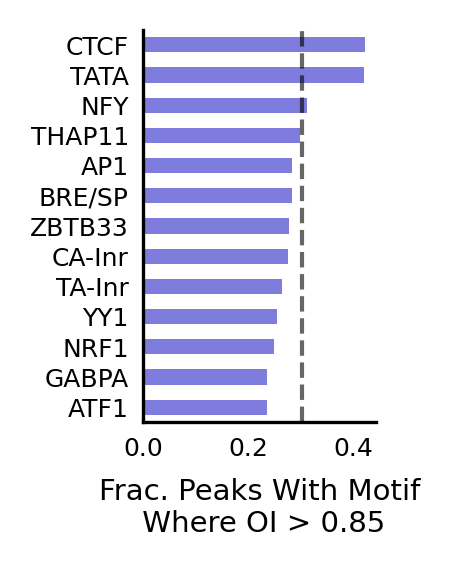

In [580]:
def plot_oi_by_motif_presence(motif_hit_counts, true_profs, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_hit_bools = motif_hit_counts > 0
    
    ois = get_orientation_indexes(true_profs)
    
    oi_bools = ois > 0.85
    
    ois_with_motifs = []
    for motif_key in range(num_motifs):
        oi_bools_with_motif = oi_bools[motif_hit_bools[:, motif_key]]
        ois_with_motifs.append(np.sum(oi_bools_with_motif) / len(oi_bools_with_motif))
    
    plot_order = np.argsort(ois_with_motifs)
    ois_with_motifs_ordered = [ois_with_motifs[i] for i in plot_order]
    motif_keys_to_labels_ordered = [motif_keys_to_labels[i] for i in plot_order]
    
    plt.figure(figsize=(1.,1.7), dpi=300)
    
    plt.barh(range(num_motifs), ois_with_motifs_ordered, height=0.5, color="#7e7dde")
    
    plt.axvline(np.sum(oi_bools) / len(oi_bools), linestyle="dashed", c="k", linewidth=1, alpha=0.6)

    plt.yticks(range(num_motifs), motif_keys_to_labels_ordered, fontsize=7)
    plt.tick_params(left=False, length=0, labelsize=6)
    plt.xlabel("Frac. Peaks With Motif\n Where OI > 0.85", fontsize=7)
    plt.ylim(0 - 0.5, num_motifs - 0.5)
    
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
        
plot_oi_by_motif_presence(motif_hit_counts["profile"], true_profs)

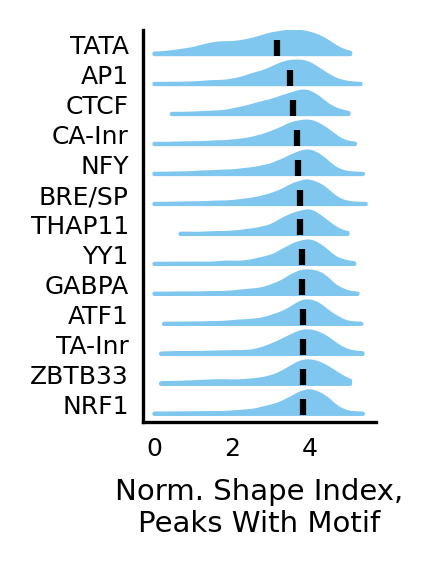

In [626]:
def get_shannon_entropies(profiles):
    assert len(profiles.shape) >= 2, profiles.shape
    profiles_strand_sum = profiles.sum(axis=-2)
    
    profiles_norm = profiles_strand_sum / profiles_strand_sum.sum(axis=-1, keepdims=True)
    profiles_norm_log = np.log(profiles_norm + 1e-20)
    
    entropies = - (profiles_norm * profiles_norm_log).sum(axis=-1)
    return entropies


def plot_shannon_entropy_by_motif_presence(motif_hit_counts, true_profs, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_hit_bools = motif_hit_counts > 0
    
    ses = get_shannon_entropies(true_profs)
    
    norm_ses = ses / np.log(np.log(true_profs.sum(axis=(-1,-2))))
    
    median_norm_ses = np.median(norm_ses, axis=-1)
    
    ses_with_motifs = []
    for motif_key in range(num_motifs):
        ses_with_motif = ses[motif_hit_bools[:, motif_key]]
        ses_with_motifs.append(ses_with_motif)
    
    median_ses_with_motifs = [np.median(ses_with_motif) for ses_with_motif in ses_with_motifs]
    
    plot_order = np.argsort(median_ses_with_motifs)[::-1]
    ses_with_motifs_ordered = [ses_with_motifs[i] for i in plot_order]
    motif_keys_to_labels_ordered = [motif_keys_to_labels[i] for i in plot_order]
    median_ses_with_motifs_ordered = [median_ses_with_motifs[i] for i in plot_order]
    
    plt.figure(figsize=(1.,1.7), dpi=300)
    
    v1 = plt.violinplot(ses_with_motifs_ordered, range(num_motifs),
                        showmeans=False, showextrema=False, showmedians=False,
                        widths=1.5, vert=False)
    
    for b in v1['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 1])
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], m, np.inf)

        b.set_edgecolor("#80c7f0")
        b.set_facecolor("#80c7f0")
        b.set_alpha(1)

    plt.scatter(median_ses_with_motifs_ordered, np.arange(num_motifs) + 0.2,
                marker="|", c="k", s=15, zorder=1)
    
    #plt.barh(range(num_motifs), ois_with_motifs_ordered, height=0.5, color="#7e7dde")
    
    #plt.axvline(np.sum(oi_bools) / len(oi_bools), linestyle="dashed", c="k", linewidth=1, alpha=0.6)

    plt.yticks(np.arange(num_motifs) + 0.3, motif_keys_to_labels_ordered, fontsize=7)
    plt.tick_params(left=False, length=0, labelsize=6)
    plt.xlabel("Norm. Shape Index,\nPeaks With Motif", fontsize=7)
    plt.ylim(0 - 0.3, num_motifs - 0.2)
    
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
        
plot_shannon_entropy_by_motif_presence(motif_hit_counts["profile"], true_profs)

## Motif Co-occurrence

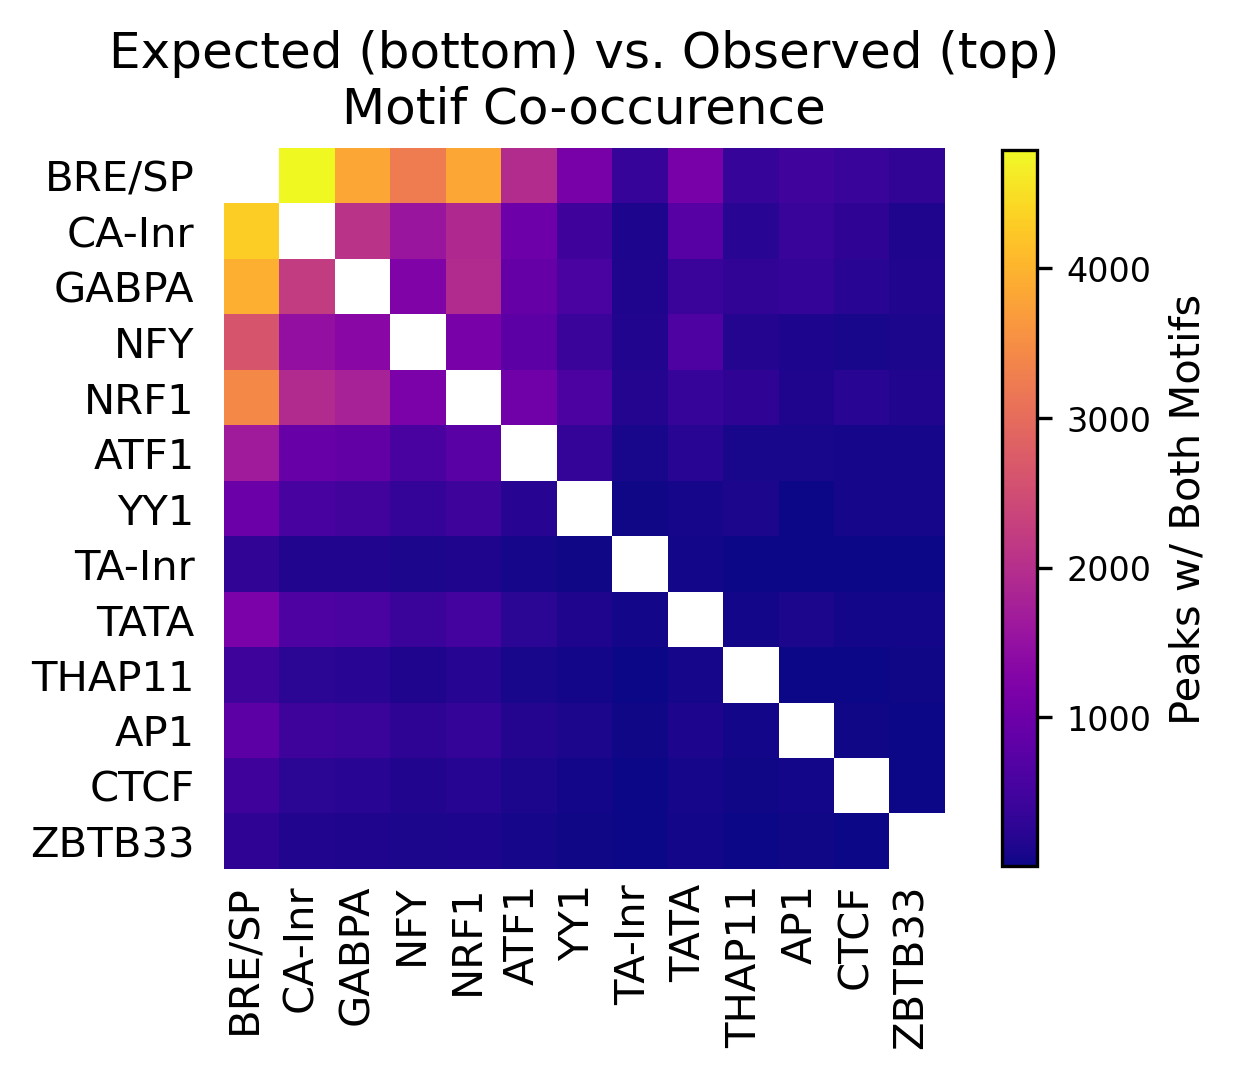

In [292]:
from collections import defaultdict


def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix


def plot_motif_cooccurrence(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  #/ peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :]) * peak_hit_counts.shape[0] ####

    combo_matrix = combine_two_symmetric_matrices(motif_frac_matrix, motif_cooccur_fracs)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Peaks w/ Both Motifs",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.title("Expected (bottom) vs. Observed (top)\nMotif Co-occurence")
    plt.show()
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"])

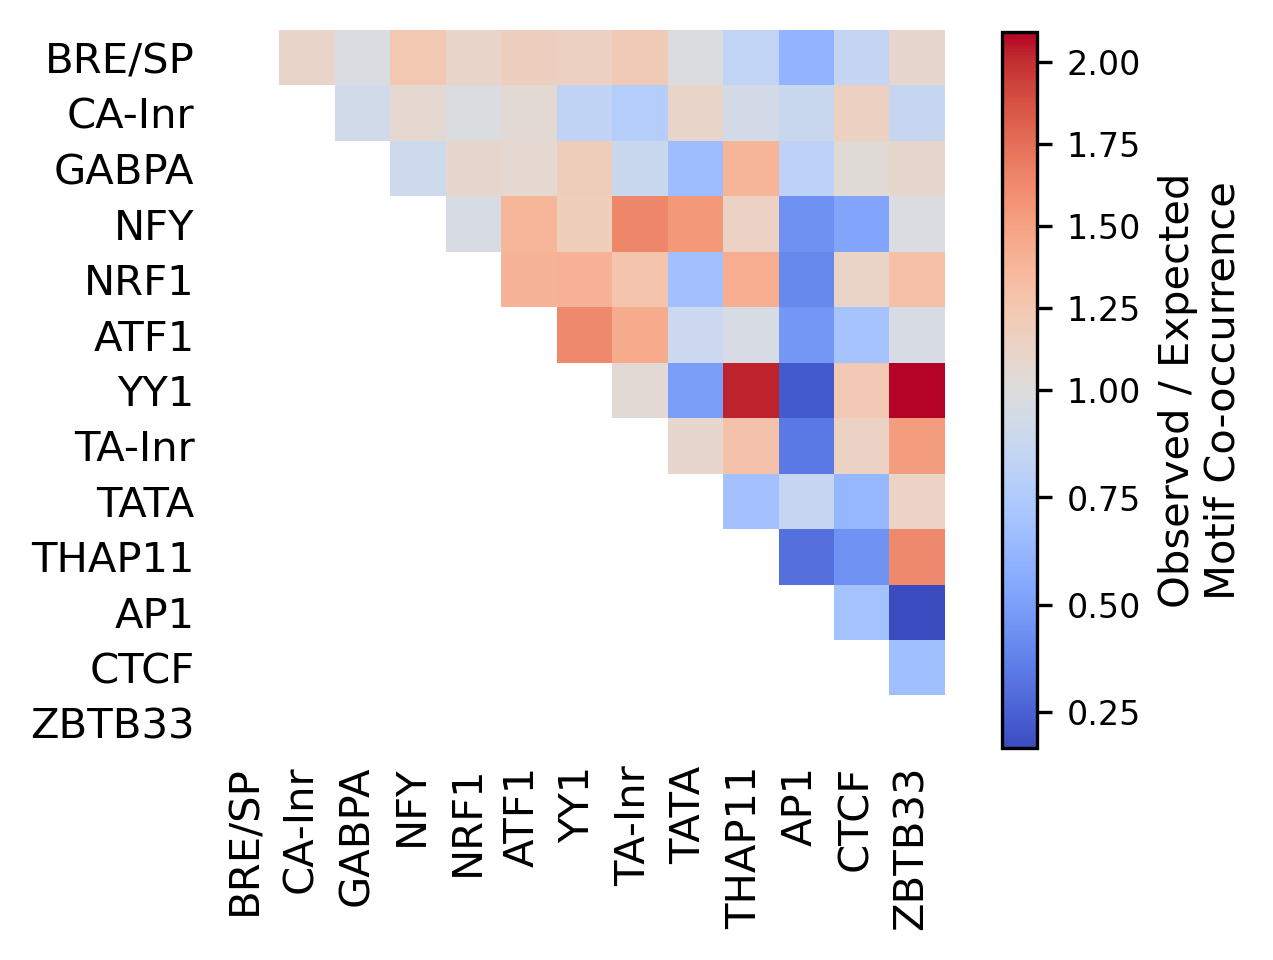

In [324]:
from collections import defaultdict
from matplotlib import colors



def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix


def plot_motif_cooccurrence(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  / peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :])

    motif_cooccur_enrichment = motif_cooccur_fracs / motif_frac_matrix
    
    combo_matrix = combine_two_symmetric_matrices(np.full_like(motif_frac_matrix, np.nan),
                                                  motif_cooccur_enrichment)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=np.min(combo_matrix[~np.isnan(combo_matrix)]),
                                                                       vcenter=1.,
                                        vmax=np.max(combo_matrix[~np.isnan(combo_matrix)])))
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Observed / Expected\nMotif Co-occurrence",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"])

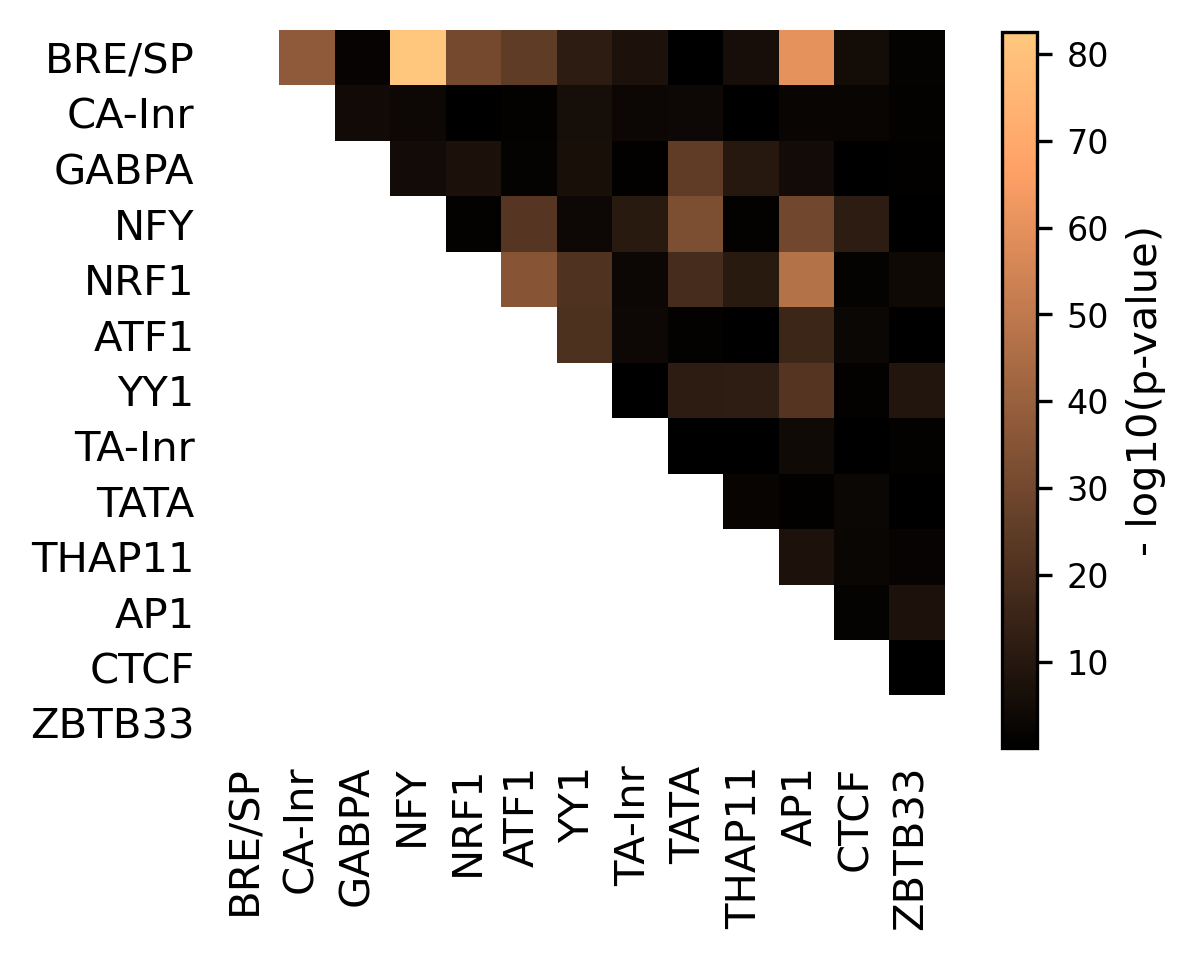

In [328]:
import scipy

def compute_cooccurrence_pvals(peak_hit_counts):
    """
    Given the number of motif hits in each peak, computes p-value of
    co-occurrence for each pair of motifs, including self pairs.
    Returns an M x M array of p-values for the M motifs.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_peaks, num_motifs = peak_hit_counts.shape
    
    pvals = np.ones((num_motifs, num_motifs))
    
    # Significance is based on a Fisher's exact test. If the motifs were
    # present in peaks randomly, we'd independence of occurrence.
    # For self-co-occurrence, the null model is not independence, but
    # collisions
    for i in range(num_motifs):
        for j in range(i):
            pair_counts = peak_hit_indicators[:, [i, j]]
            peaks_with_1 = pair_counts[:, 0] == 1
            peaks_with_2 = pair_counts[:, 1] == 1
            # Contingency table (universe is set of all peaks):
            #              no motif 1  |  has motif 1
            # no motif 2       A       |      B
            # -------------------------+--------------
            # has motif 2      C       |      D
            # The Fisher's exact test evaluates the significance of the
            # association between the two classifications
            cont_table = np.array([
                [
                    np.sum(~(peaks_with_1) & (~peaks_with_2)),
                    np.sum(peaks_with_1 & (~peaks_with_2))
                ],
                [
                    np.sum(~(peaks_with_1) & peaks_with_2),
                    np.sum(peaks_with_1 & peaks_with_2)
                ]
            ])
            pval = scipy.stats.fisher_exact(
                cont_table, alternative="two-sided"
            )[1]
            pvals[i, j] = pval
            pvals[j, i] = pval

        # Self-co-occurrence: Poissonize balls in bins
        # Expected number of collisions (via linearity of expectations):
        num_hits = np.sum(peak_hit_indicators[:, i])  # number of "balls"
        expected_collisions = num_hits * (num_hits - 1) / (2 * num_peaks)
        num_collisions = np.sum(peak_hit_counts[:, i] >= 2)
        pval = 1 - scipy.stats.poisson.cdf(num_collisions, mu=expected_collisions)
        pvals[i, i] = pval
    
    return pvals

def plot_pvals(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    neg_log_pvals = - np.log10(compute_cooccurrence_pvals(peak_hit_counts))
    
    #neg_log_pvals[neg_log_pvals < 5] = np.nan
    
    matrix_to_plot = combine_two_symmetric_matrices(np.full_like(neg_log_pvals, np.nan),
                                                    neg_log_pvals)
    
    num_motifs = len(motif_keys_to_labels)
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(matrix_to_plot, cmap="copper")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="- log10(p-value)",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    

plot_pvals(motif_hit_counts["profile"])

## Supplemental

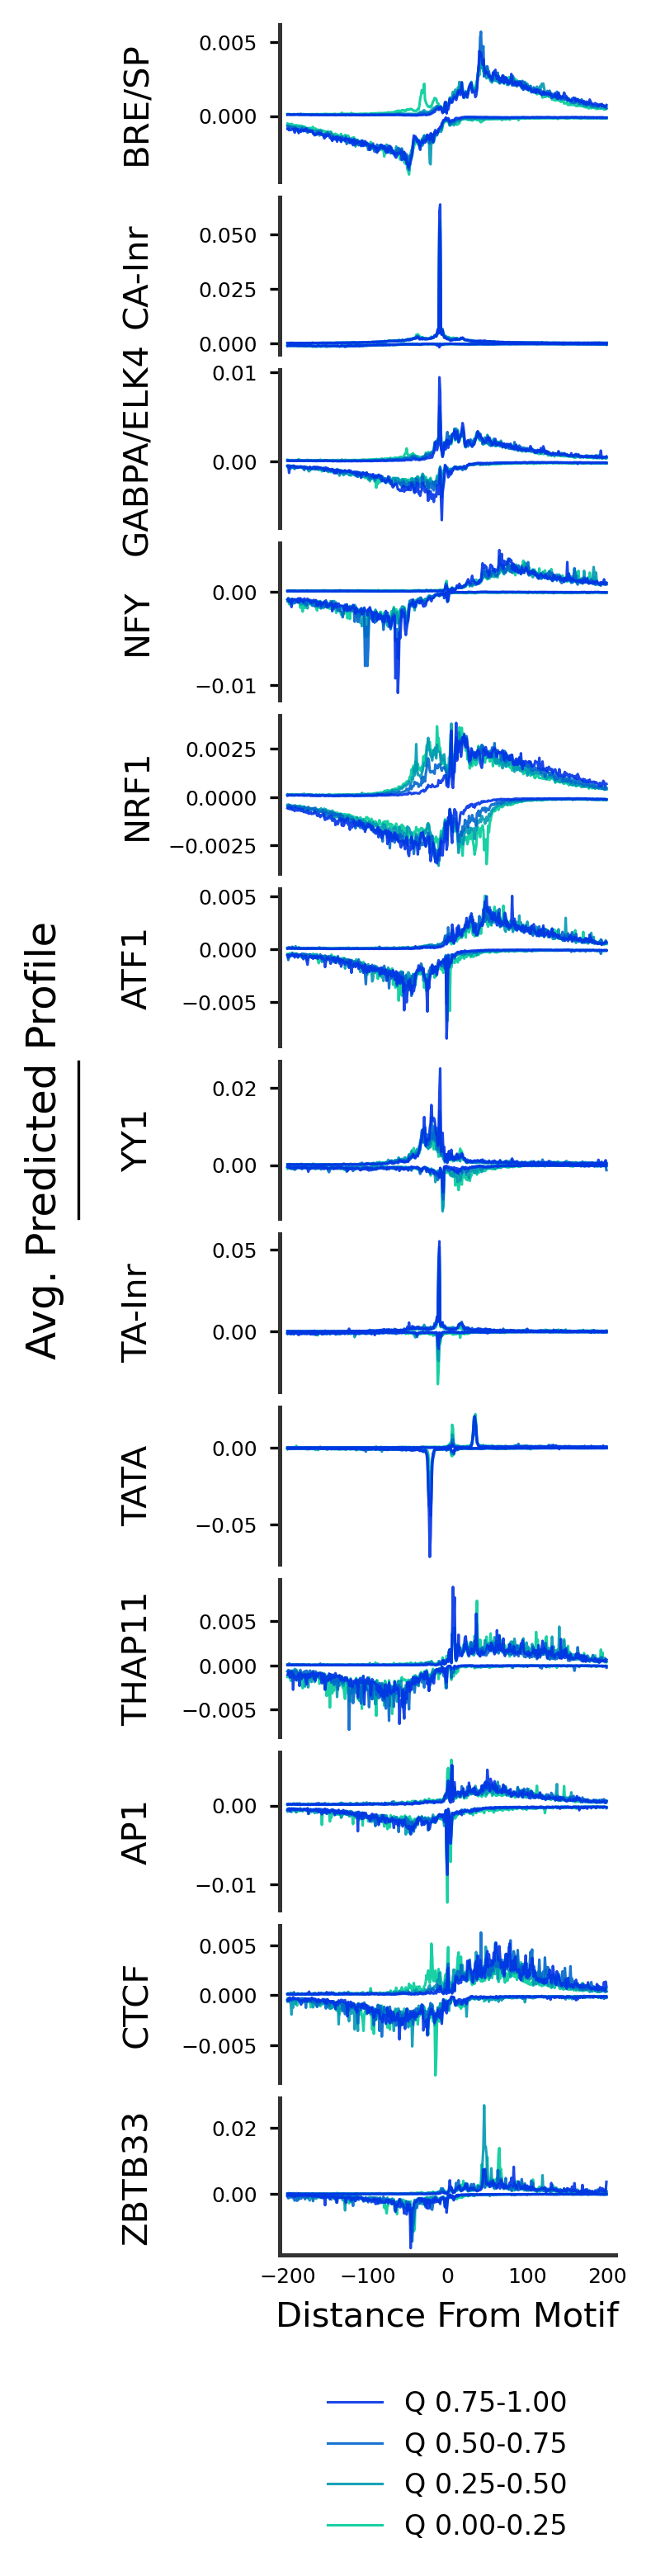

In [87]:
from data_loading import one_hot_encode
import matplotlib.colors as colors
import matplotlib.cm as cmx

# only used in supplement fig rn
onehot_seqs = load_sequences(genome_path,
                             chrom_sizes,
                             peak_path,
                             slice_len=slice_len,
                             in_window=in_window)


def score_seq_by_cwm(cwm, seq):
    if type(seq) == str:
        seq = one_hot_encode(seq)
    return np.multiply(seq, cwm).sum()


def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 200):
        
    def convert_motif_coords_to_seq_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - onehot_seqs.shape[1]) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
            #print(peak_start, peak_end, start, end, real_start)
        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, coord_indexes,
                                                                  motif_starts, motif_ends)
    
    # For each seqlet, fetch the sequence
    motif_seqs = []
    for coord_index, motif_start, motif_end, rc in zip(coord_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        if not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > onehot_seqs.shape[1]):
            seq = onehot_seqs[coord_index, motif_start:motif_end]
            if rc:
                seq = seq[::-1, ::-1]
            motif_seqs.append(seq)

    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


# this is also in 5_modisco/report_utils.py
def compute_per_position_ic(ppm, background=np.array([0.25] * 4), pseudocount=0.001):
    alphabet_len = len(background)
    #ppm = np.abs(ppm)
    ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
          *ppm - (np.log(background)*background/np.log(2))[None,:])
    return np.sum(ic,axis=1)

# frankensteined together from how the hit caller code trims
def trim_by_ic(ppm, seq, target_len=25):
    per_pos_ic = compute_per_position_ic(seq)
    
    best_i = -1
    best_sum = 0
    for i in range(ppm.shape[0] - target_len + 1):
        new_sum = np.sum(per_pos_ic[i : i + target_len])
        if new_sum > best_sum:
            best_sum = new_sum
            best_i = i

    return ppm[best_i:best_i + target_len]


def plot_affinity_vs_profiles(modisco_results, onehot_seqs,
                      patterns_to_keep, motif_hits,
                      coords, true_profs, pred_profs, 
                      in_window, out_window, slice_len,
                      prof_width=200):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    cwm_score_list = []
    true_profs_list = []
    pred_profs_list = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        # need to trim here because the hit caller trimmed
        cwm_trimmed = trim_by_ic(pattern["contrib_scores"][:], pattern["sequence"][:])

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["key"] == ax_row_i]

        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)
        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq) for seq in motif_seqs])
        cwm_score_list.append(seq_scores)
        
        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     slice_len, prof_width=prof_width)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)
        
        
    xrange = range(-prof_width, prof_width)
    num_quantiles = 4
    alpha_range = lambda plot_i : 0.1 + plot_i * (0.9 / num_quantiles)
    
    cNorm  = colors.Normalize(vmin=0, vmax=num_quantiles+1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('winter'))
    
    fig, axes = plt.subplots(len(patterns_to_keep), figsize=(1.75,0.9 * len(patterns_to_keep)),
                             dpi=300)
    plt.subplots_adjust(hspace=0.1)
    
    middle_ax_i = len(patterns_to_keep) // 2
    
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        
        pred_profs = pred_profs_list[ax_row_i]
        seq_scores = cwm_score_list[ax_row_i]
        
        quantiles = np.arange(0,1.1,1/num_quantiles)
        q_scores = np.quantile(seq_scores, quantiles)
        quantile_tups = [(q_scores[i], q_scores[i+1]) for i in range(len(q_scores)-1)]

        
        for cat_i, (low_q, high_q) in enumerate(quantile_tups):
            in_quantile_bools = np.array([score >= low_q and score < high_q for score in seq_scores])
            avg_profs_subset = pred_profs[in_quantile_bools].mean(axis=0)
            
            axes[ax_row_i].plot(xrange, avg_profs_subset[0],
                     alpha = 0.9, linewidth=0.75,
                     c=scalarMap.to_rgba(num_quantiles - cat_i),
                     label = "Q %0.2f-%0.2f" % (quantiles[cat_i], quantiles[cat_i + 1]))
            axes[ax_row_i].plot(xrange, -1 * avg_profs_subset[1],
                     alpha = 0.9, linewidth=0.75,
                     c=scalarMap.to_rgba(num_quantiles - cat_i))
        
        axes[ax_row_i].set_ylabel(motif_keys_to_labels[ax_row_i], fontsize=10)
        
        if ax_row_i == middle_ax_i:
            ax2 = axes[ax_row_i].twinx()
            ax2.spines["left"].set_position(("axes", -0.6))
            
            ax2.yaxis.set_label_position('left')
            ax2.yaxis.set_ticks_position('none')
            ax2.set_yticks([])
            ax2.set_xticks([])
            for side in ["bottom", "top", "right"]:
                ax2.spines[side].set_visible(False)
                
            ax2.set_ylabel("Avg. Predicted Profile", fontsize=12)

        axes[ax_row_i].set_xlim(-prof_width - 10, prof_width + 10)
        
        if ax_row_i == len(patterns_to_keep) - 1:
            axes[ax_row_i].set_xlabel("Distance From Motif", fontsize=10)
            axes[ax_row_i].spines["bottom"].set_linewidth(1.2)
            axes[ax_row_i].spines["bottom"].set_color("#333333")
            axes[ax_row_i].tick_params("x", length=0, labelsize=6)
        else:
            axes[ax_row_i].spines["bottom"].set_visible(False)
            axes[ax_row_i].set_xticks([])
        
        axes[ax_row_i].spines["left"].set_linewidth(1.2)
        axes[ax_row_i].spines["left"].set_color("#333333")
        axes[ax_row_i].spines["top"].set_visible(False)
        axes[ax_row_i].spines["right"].set_visible(False)
        axes[ax_row_i].tick_params("y", length=3, labelsize=6)
        
    fig.align_ylabels()
    
    handles,labels = axes[-1].get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]
    axes[ax_row_i].legend(handles, labels,
               bbox_to_anchor=(0.5, -0.7), loc='upper center',
               frameon=False, fontsize=8)
    
    plt.show()

        
plot_affinity_vs_profiles(modisco_results, onehot_seqs,
                  patterns_to_keep, motif_hits,
                  coords, true_profs, pred_profs,
                  in_window, out_window, slice_len)

In [ ]:
# old unused code

In [ ]:
def get_n_seqlets_for_pattern(modisco_results, pattern_i):
    if pattern_i < 0:
        pattern_type = "neg_patterns"
        pattern_i = np.abs(pattern_i) - 1
    else:
        pattern_type = "pos_patterns"
    
    patterns = modisco_results[pattern_type]
    pattern_name = "pattern_" + str(pattern_i)
    return patterns[pattern_name]["seqlets"]['n_seqlets'][:][0]
    

def get_counts_task_seqlets(counts_modisco_results, profile_to_counts_patterns):
    seqlet_counts = dict()
    for profile_key, counts_patterns in profile_to_counts_patterns.items():
        if counts_patterns is None:
            seqlet_counts[profile_key] = np.nan
        elif type(counts_patterns) == int:
            seqlet_counts[profile_key] = get_n_seqlets_for_pattern(counts_modisco_results, counts_patterns)
        else:
            n_seqlets = 0
            for counts_pattern in counts_patterns:
                n_seqlets += get_n_seqlets_for_pattern(counts_modisco_results, counts_pattern)
            seqlet_counts[profile_key] = n_seqlets
    return seqlet_counts

counts_seqlets = get_counts_task_seqlets(counts_modisco_results, profile_to_counts_patterns)


def extract_profs_at_seqlets(seqlets, coords, true_profs, pred_profs,
                             in_window, out_window, slice_len, prof_width=200):
        
    #def seqlet_coord_to_input_coord(seqlet_coord):
    #    return seqlet_coord + ((in_window - slice_len) // 2)
        
    #def convert_seqlet_coords_to_genomic_coords(coord_indexes, seqlet_starts, seqlet_ends, pred_coords):
    #    input_starts = seqlet_coord_to_input_coord(seqlet_starts)
    #    input_ends = seqlet_coord_to_input_coord(seqlet_ends)
        
    #    genomic_coords = []
    #    for coord_index, input_start, input_end in zip(coord_indexes, input_starts, input_ends):
    #        chrom, peak_start, _, _, _ = pred_coords[coord_index]
    #        genomic_coords.append([chrom, peak_start + input_start, peak_start + input_end])
            
    #    return genomic_coords
    
    def seqlet_coord_to_profile_coord(seqlet_coord):
        return seqlet_coord + ((in_window - slice_len) // 2) - ((in_window - out_window) // 2)
        
    coord_indexes = seqlets["example_idx"][:]
    seqlet_starts = seqlets["start"][:]
    seqlet_ends = seqlets["end"][:]
    seqlet_rcs = seqlets["is_revcomp"][:]
    
    # Get indices of profile above seqlet
    seqlet_centers = (seqlet_starts + seqlet_ends) // 2
    prof_centers = seqlet_coord_to_profile_coord(seqlet_centers)
    prof_starts = prof_centers - prof_width
    prof_ends = prof_starts + prof_width * 2
    
    # For each seqlet, fetch the true/predicted profiles
    true_seqlet_profs = []
    pred_seqlet_profs = []
    for coord_index, prof_start, prof_end, rc in zip(coord_indexes, prof_starts, prof_ends, seqlet_rcs):
        if prof_start < 0 or prof_end > out_window:
            # don't use profile for this example since indexes go past the profile end  - Kelly
            true_prof = np.full((true_profs.shape[-2], prof_width * 2), np.nan)
            pred_prof = np.full((true_profs.shape[-2], prof_width * 2), np.nan)
        else:
            true_prof = true_profs[coord_index, :, prof_start:prof_end]
            pred_prof = pred_profs[coord_index, :, prof_start:prof_end]
        
        if rc:
            true_prof = true_prof[::-1, ::-1]
            pred_prof = pred_prof[::-1, ::-1]
        
        true_seqlet_profs.append(true_prof)
        pred_seqlet_profs.append(pred_prof)  
    
    true_seqlet_profs = np.stack(true_seqlet_profs)
    pred_seqlet_profs = np.stack(pred_seqlet_profs)
    
    return true_seqlet_profs, pred_seqlet_profs